# Jitter Fisher Analysis

Telescope jitter will negatively effect an inference algorithm's ability to constrain all its other parameters. In the case of the TOLIMAN telescope, we are primarily concerned with the ability to constrain the binary separation. In this notebook we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters.

First let's configure the notebook.

In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

## Building Model
Here we build our dLux forwards model with parametric jitter.

In [2]:
oversample = 8
det_pscale = 0.375
det_npixels = 128
kernel_size = 15

jitter_params = {"r": 1e-3, "shear": 0, "phi": 0}  # these will vary
radial_orders = [2, 3]

In [3]:
src = dlT.AlphaCen()
det = dl.LayeredDetector([
    ('Jitter', dlT.GaussianJitter(**jitter_params, kernel_size=kernel_size)),
    ('Downsample', dl.Downsample(oversample)),
])

osys = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_pixel_scale=det_pscale,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    )
osys = osys.divide('aperture.basis', 1e9) # Set basis units to nanometers

telescope = dl.Telescope(source=src, optics=osys, detector=det)


## Visualising the Jitter Parameters
Our jitter parameters are $r$, shear and $\phi$. $r$ is the magnitude of the jitter in pixels, $\phi$ is the angle of the jitter in degrees and shear is a measure of how linear the jitter is.

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_5071/1385424295.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax0.set(title=f'r={r}, shear={shear}, $\phi$={phi}')


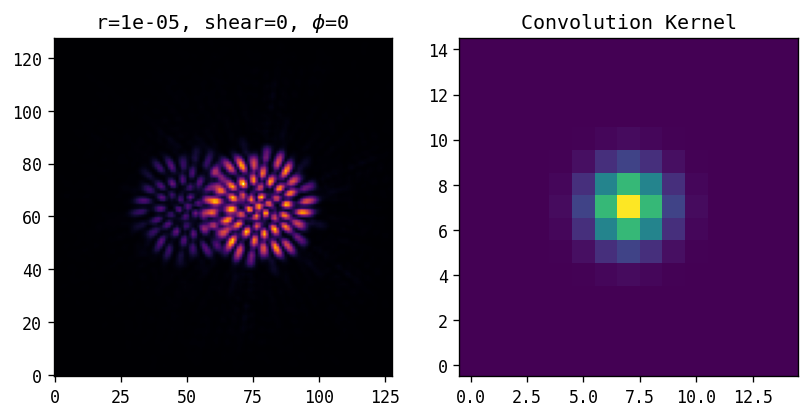

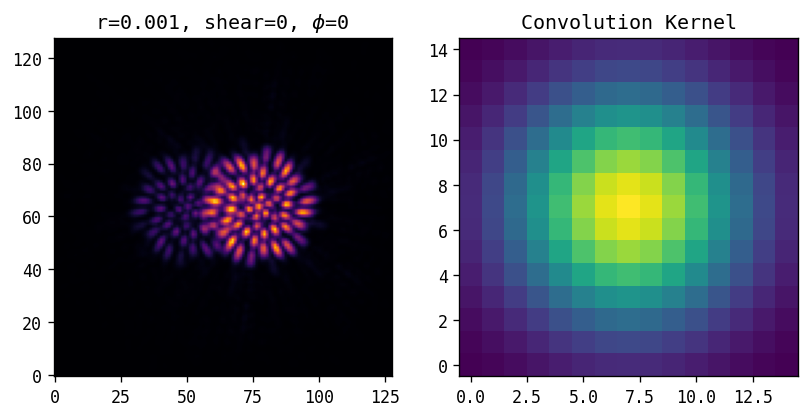

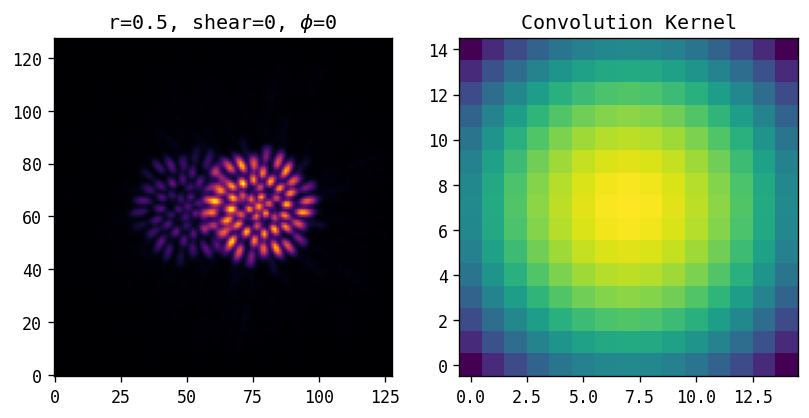

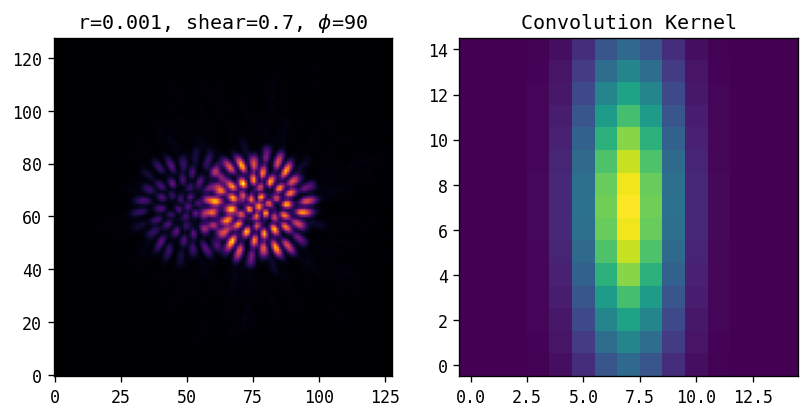

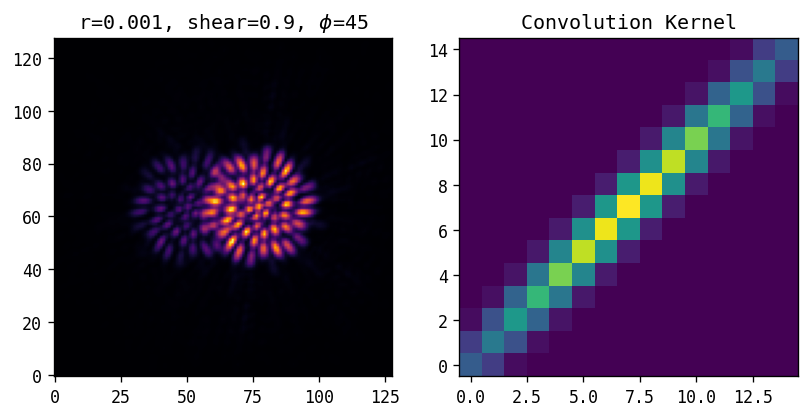

In [27]:
def show_jitter_example(instrument, r, shear, phi):
    example_model = instrument.set(['detector.Jitter.r', 'detector.Jitter.shear', 'detector.Jitter.phi'], [r, shear, phi])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    ax0.imshow(example_model.model())
    ax0.set(title=f'r={r}, shear={shear}, $\phi$={phi}')
    c = ax1.imshow(example_model.detector.Jitter.generate_kernel(det_pscale/oversample), cmap='viridis')
    ax1.set(title='Convolution Kernel')
    plt.show()

show_jitter_example(telescope, 1e-5, 0, 0)
show_jitter_example(telescope, 1e-3, 0, 0)
show_jitter_example(telescope, 0.5, 0, 0)
show_jitter_example(telescope, 1e-3, 0.7, 90)
show_jitter_example(telescope, 1e-3, 0.9, 45)

# Investigating Kernel Oversample
The convolution kernel is a multivariate normal generated on a coordinate grid (using `jax.scipy.stats.multivariate_normal`), however if the coordinate grid is not well-sampled, this can lead to some dodgy-looking kernels. To get around this, the kernels are generated on an oversampled grid (determined by the `Jitter.kernel_oversample` parameter), and the kernel is then downsampled before convolution. Here we investigate the residuals between an "ideal" PSF (with an arbitrarily large `kernel_oversample`) and the PSF of varying `kernel_oversample` values, to determine the ideal `kernel_oversample` to use later such that it comprimises between error and compute time.

In [28]:
# mags = np.array([2e-4, 5e-4, 1e-3])  # magnitude (r) values to investigate
# ko_resss = []
# kos = np.array([1, 2, 4, 9, 16, 25, 36])

# for mag in mags:
#     tel = telescope.set(["Jitter.r", "Jitter.kernel_oversample"], [mag, 100])
#     ideal = tel.Jitter.generate_kernel(det_pscale*tel.oversample)
#     ress = []

#     for ko in kos:
#         tel = tel.set("Jitter.kernel_oversample", ko)
#         res = np.abs(tel.Jitter.generate_kernel(det_pscale*tel.oversample) - ideal).sum() 
#         ress.append(res)

#     ress = 100 * np.array(ress) / ideal.sum()
#     ko_resss.append(ress)

In [29]:
# # kernel oversample
# fig, ax = plt.subplots(figsize=(7,3))
# for mag, ress in zip(mags, ko_resss):
#     ax.plot(kos, ress, marker='^', label=f'$r={mag}$')
# ax.axhline(0, color='k')
# ax.set(
#     xlabel='`kernel_oversample`',
#     ylabel='Fractional Kernel Residual (%)',
#     xlim=(0, None),
#     ylim=(0, None),
#     title='Finding optimal kernel oversampling'
# )
# ax.grid(alpha=0.2)
# ax.legend()
# plt.show()

Kernel size is not particularly significant in this regime.

# Finding optimal optics oversample

In [30]:
# mags = np.array([2e-4, 5e-4, 1e-3])  # magnitude (r) values to investigate
# o_resss = []
# os = np.array([2, 4, 8, 16])

# for mag in tqdm(mags):
#     tel = telescope.set(["Jitter.r", "oversample", "Downsample.kernel_size"], [mag, 128, 128])
#     ideal = tel.model()
#     ress = []

#     for o in tqdm(os):
#         tel = tel.set(["oversample", "Downsample.kernel_size"], [o, o])
#         res = np.abs(tel.model() - ideal).sum() 
#         ress.append(res)

#     ress = 100 * np.array(ress) / ideal.sum()
#     o_resss.append(ress)

In [31]:
# # kernel oversample
# fig, ax = plt.subplots(figsize=(7,3))
# for mag, ress in zip(mags, o_resss):
#     ax.plot(os, ress, marker='^', label=f'$r={mag}$')
# ax.axhline(0, color='k')
# ax.set(
#     xlabel='`kernel_oversample`',
#     ylabel='Fractional Kernel Residual (%)',
#     xlim=(0, None),
#     ylim=(0, None),
#     title='Finding optimal kernel oversampling'
# )
# ax.grid(alpha=0.2)
# ax.legend()
# plt.show()

## Fisher Analysis
Now we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters. We will do this by calculating the covariance matrix of the parameters of interest. We will then plot the standard deviation of each parameter as a function of the jitter magnitude.

Specifically we are interested in the `separation` as that is the science signal we aim to extract with TOLIMAN.

In [32]:
def fwhm_to_det(fwhm, shear):
    return (1 - shear)**2 * (fwhm/2.35482)**4

def det_to_fwhm(det, shear):
    return 2.35482 * (det / (1 - shear)**2) ** 0.25

In [33]:
# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

# We can use the shape_dict to force the shape of the perturbing parameter to be a scalar,
# resulting in the model constraining the mean value of the wavelengths array.
shape_dict = {'wavelengths': 1}

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
# calc_cov = lambda model, parameters: -np.linalg.inv(FIM(model, parameters, zdx.poiss_loglike, model.model(), shape_dict=shape_dict))
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike, shape_dict=shape_dict)
cov_fn = zdx.filter_jit(calc_cov)

# Compile
cov_fn(telescope, params);

# Bar sizes
# fwhms = np.linspace(0.1, 3 * det_pscale, 5)
phis = np.array([0, 45, 90])
shears = np.array([0, 0.3, 0.7])
rs = np.logspace(-5, np.log10(fwhm_to_det(1.01*det_pscale, shears[0])), 10)
# phis = np.array([0])


seps = []
fwhms = []
kernels = []

model = telescope

for shear_idx, shear in enumerate(shears):
    model = model.set("detector.Jitter.shear", shear)

    for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
        fwhm = det_to_fwhm(r, shear)
        fwhms.append(fwhm)
        model = model.set("detector.Jitter.r", r)

        for phi_idx, phi in enumerate(phis):        
            # skipping over different angles for shear = 0
            if shear_idx == 0 and phi_idx != 0:
                sep = np.nan
            else:
                model = model.set("detector.Jitter.phi", phi)
                cov = cov_fn(model, params)
                sep = np.sqrt(np.abs(cov[0, 0]))
                if phi_idx == 0:
                    if r == rs.max():
                        kernels.append(model.Jitter.generate_kernel(det_pscale/oversample))
                # plt.imshow(model.Jitter.generate_kernel(det_pscale))
                # plt.title(f"{shear}, {phi}, {r:.2e}, {fwhm}")
                # plt.show()
                
            # covs.append(cov)
            seps.append(sep)
        
seps = np.array(seps).reshape(len(shears), len(rs), len(phis))
fwhms = np.array(fwhms).reshape(len(shears), len(rs))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Plotting
Now we will plot the standard deviation of each parameter as a function of the jitter magnitude. We will plot the standard deviation for each shear value on a separate axis.

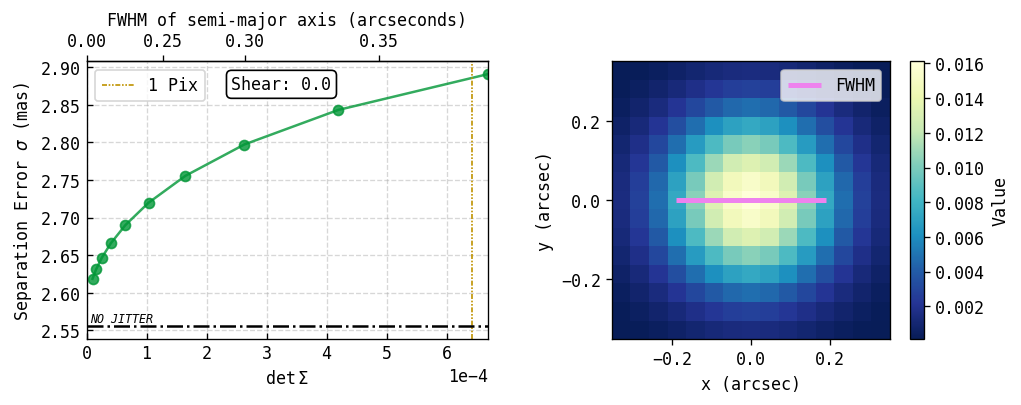

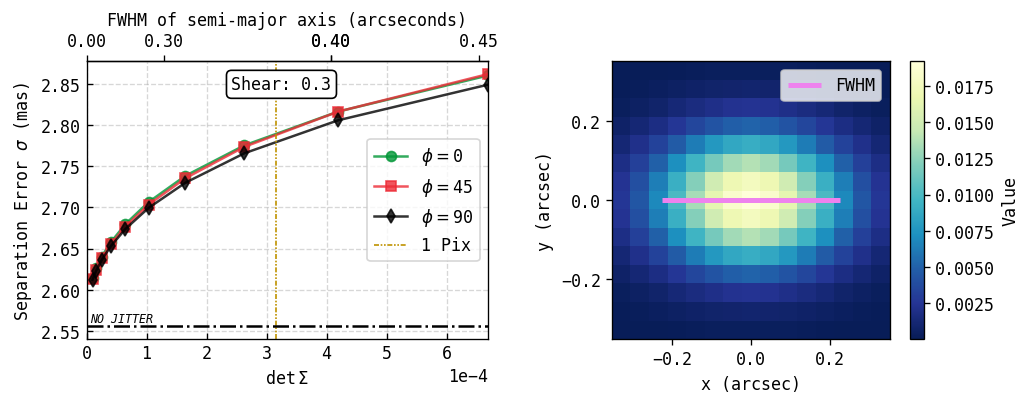

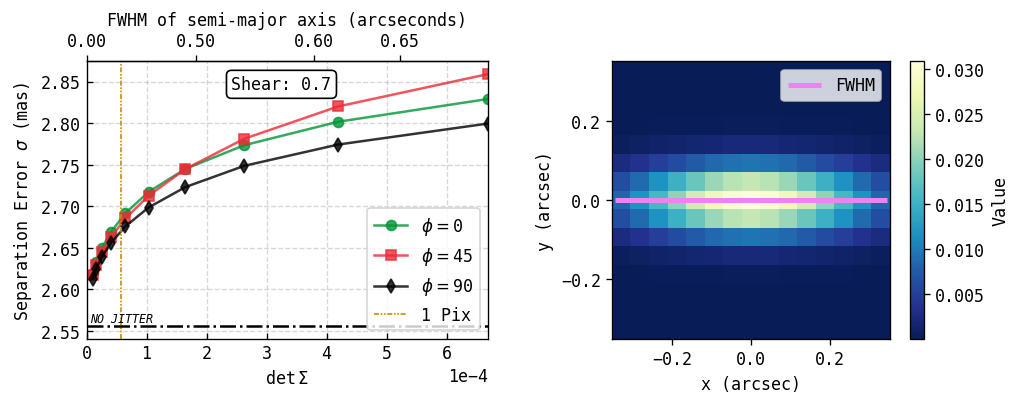

In [223]:
for i, shear in enumerate(shears):
    
    fig, (ax, axe) = plt.subplots(1, 2, figsize=(9.5, 3))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 2))

    colors = [(0, 151/256, 54/256), (238/256, 42/256, 53/256), 'k']#(192/256, 147/256, 0)]
    markers = ['o', 's', 'd']

    for sep, phi, c, m in zip(seps[i].T, phis, colors, markers):
        if shear == 0:
            label = None
        else:
            label = label=r"$\phi=$" +f"{phi:.0f}"
        ax.plot(rs, 1000 * sep, label=label, color=c, marker=m, alpha=0.8)
    ax.set(
        # title=shear,
        xlabel=r'det$\,\Sigma$',
        ylabel=r'Separation Error $\sigma$ (mas)',
        xlim=(0, rs.max()),
    )
    ax2 = ax.secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shear), lambda fwhm: fwhm_to_det(fwhm, shear)))
    # ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
    ax2.set(
        xlabel='FWHM of semi-major axis (arcseconds)',
        xticks=np.round(2*np.linspace(0, 1, 5)**.25 * det_to_fwhm(rs.max(), shear), 1)/2,
        )
    ax.axvline(x=fwhm_to_det(det_pscale, shear), linestyle=(0, (3, 1, 1, 1, 1, 1)), color=(192/256, 147/256, 0), alpha=1, linewidth=1, label='1 Pix')

    ax.text(0.61, 0.95, f"Shear: {shear}", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ax.axhline(2.5556666339644867, linestyle='-.', c='k')
    ax.text(0.01, 0.06, 'NO JITTER', transform=ax.transAxes, font='monospace', size=7, style='oblique')

    ax.tick_params(direction='in')
    # ax2.tick_params(direction='in')
    ax.legend(
        # loc='lower right',
        )
    ax.grid(True, alpha=0.5, linestyle='--')

    extent = np.array([-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2]) * det_pscale / oversample
    c=axe.imshow(
        kernels[i],
        cmap='YlGnBu_r',
        origin='lower',
        extent=extent,
        )
    axe.set(
        # title='Convolution Kernel',
        xlabel='x (arcsec)',
        ylabel='y (arcsec)',
        xticks=np.linspace(-0.2, 0.2, 3),
        yticks=np.linspace(-0.2, 0.2, 3),
    )
    max_fwhm = det_to_fwhm(rs.max(), shear)
    # axe.text(1.5, 0.95, f"FWHM: {max_fwhm:.2f}as", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    axe.hlines(0, -max_fwhm/2, max_fwhm/2, colors='violet', linestyles='solid', label='FWHM', linewidth=3)
    fig.colorbar(c, ax=axe, label='Value')
    axe.legend()
    # plt.savefig(f'figs/gaussian_jitter_{shear}.pdf', bbox_inches='tight')
    plt.show()


In [38]:
# np.save('data/jitter_stds/rs.npy', rs)
# np.save('data/jitter_stds/seps.npy', seps)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

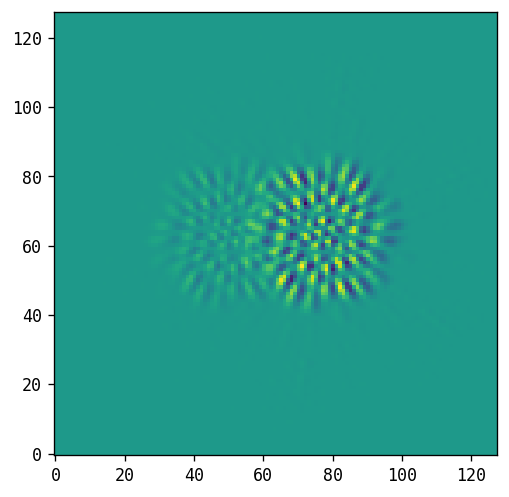

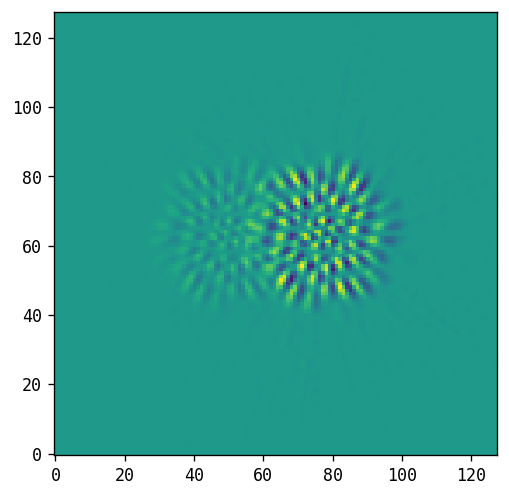

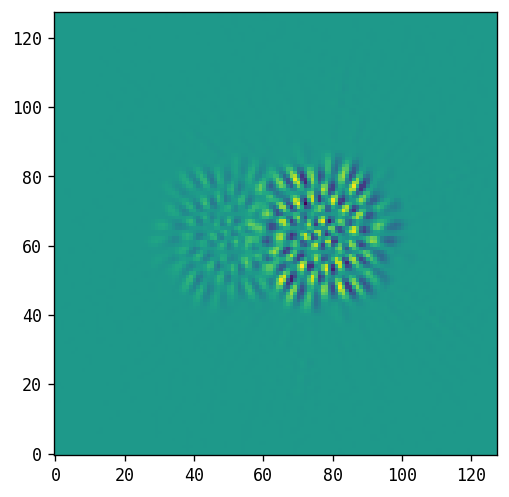

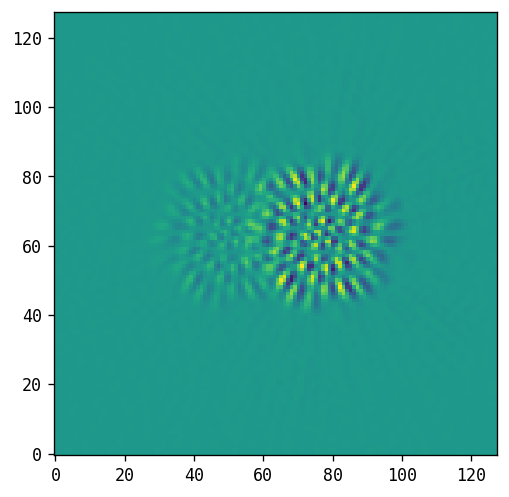

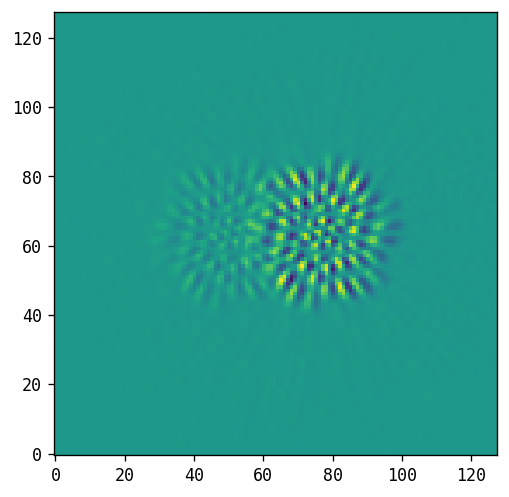

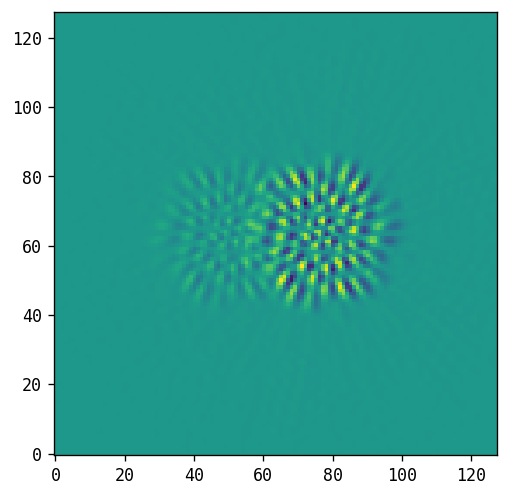

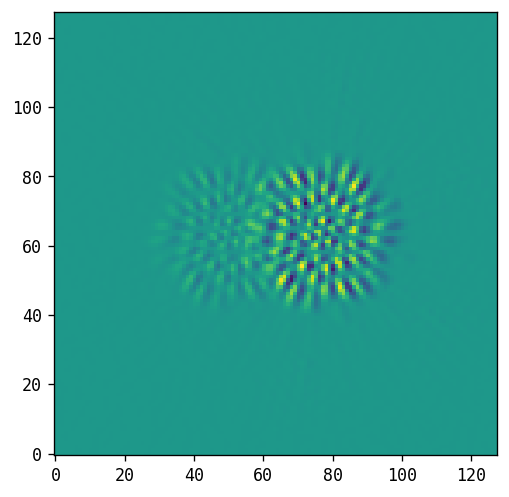

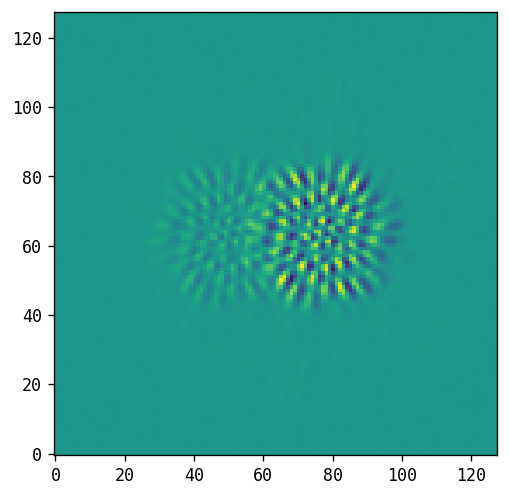

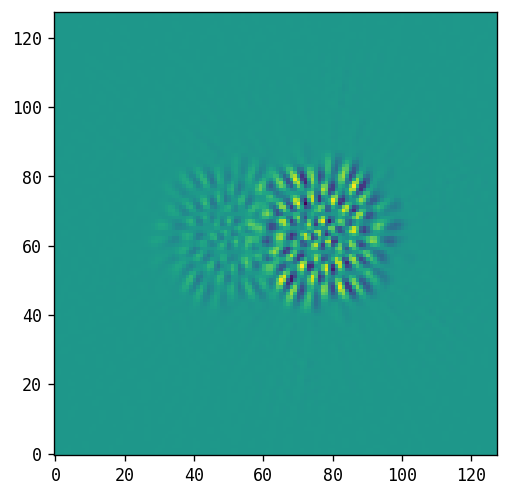

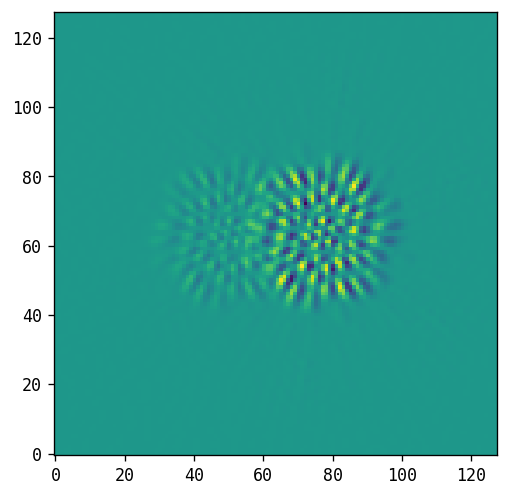

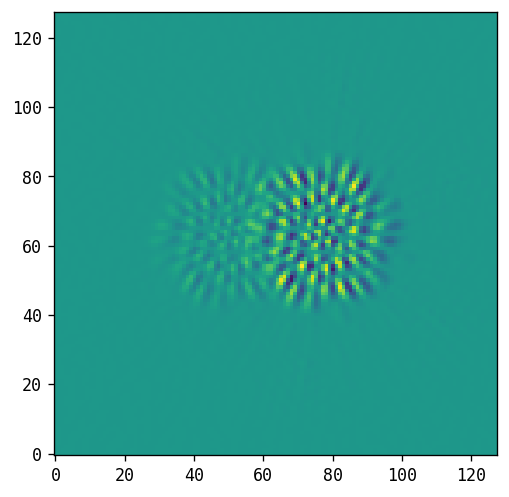

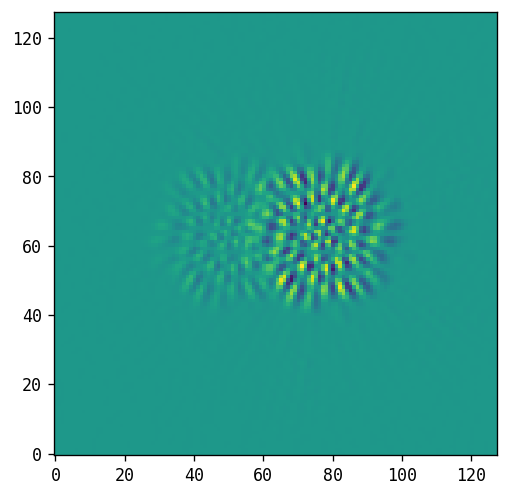

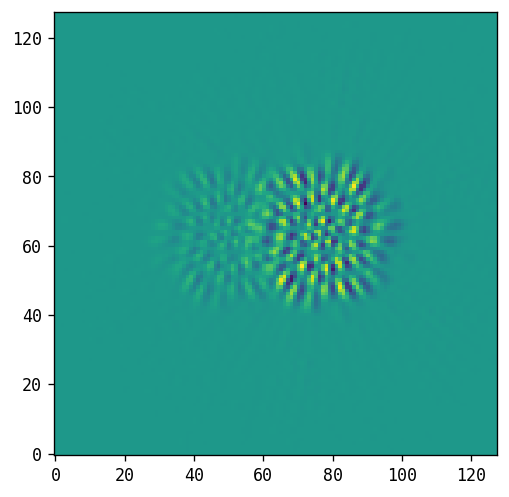

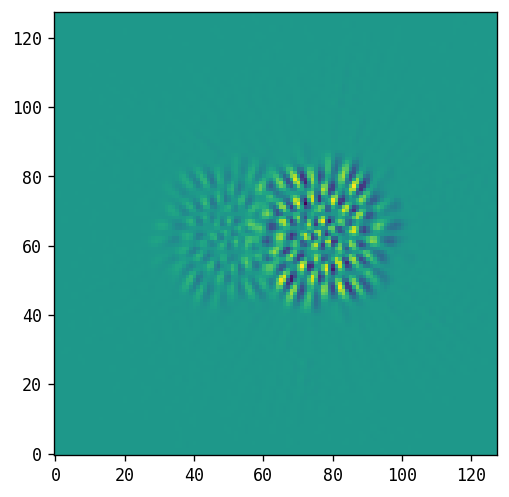

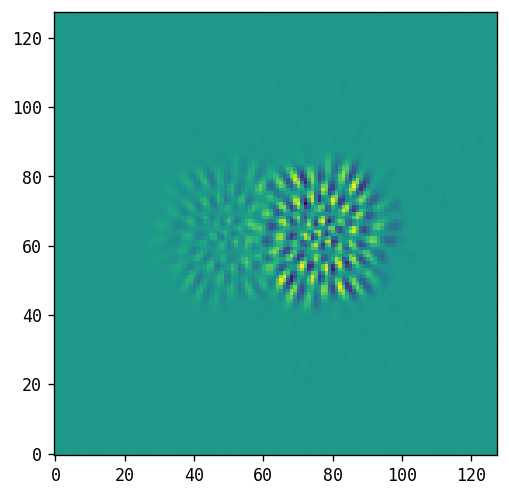

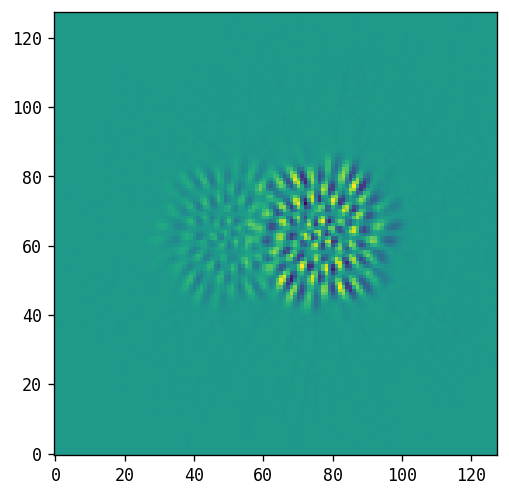

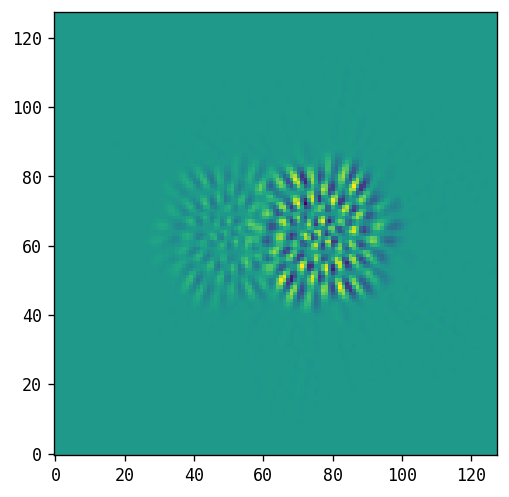

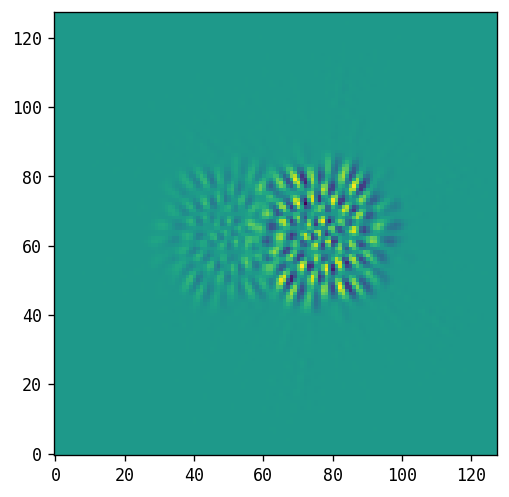

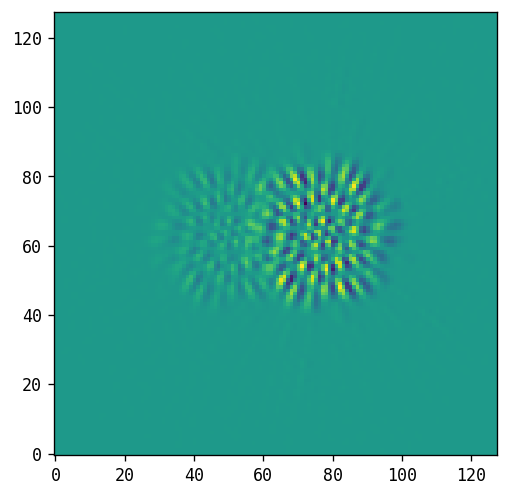

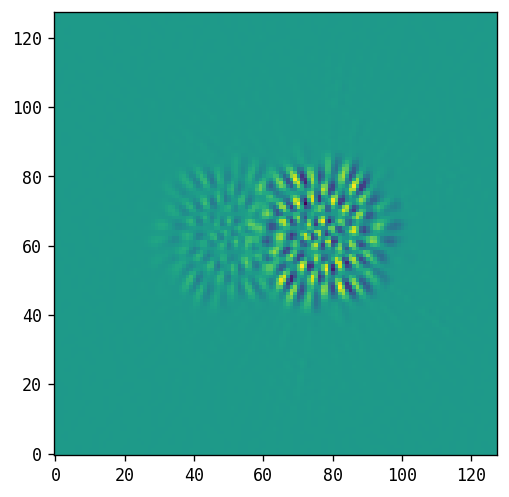

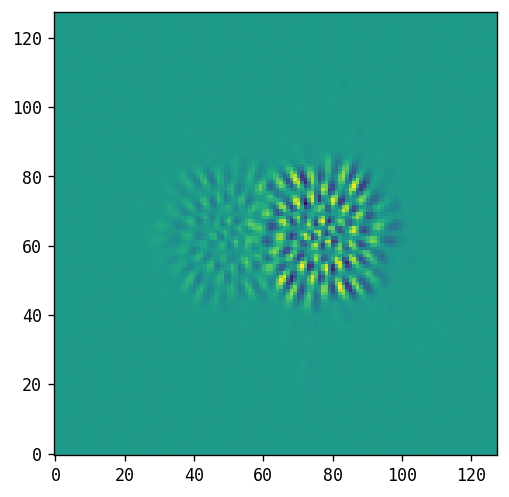

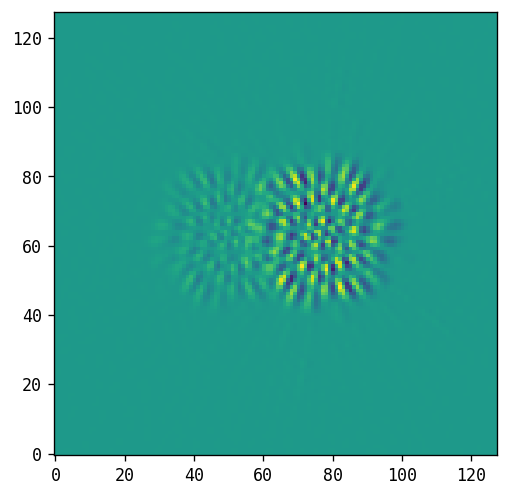

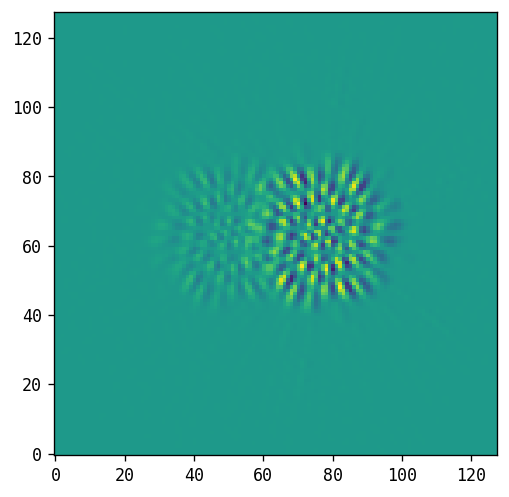

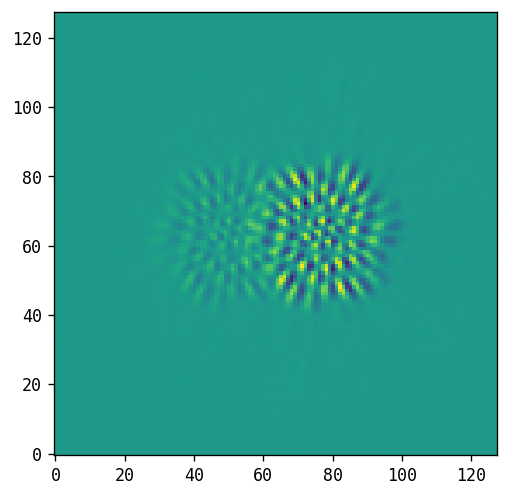

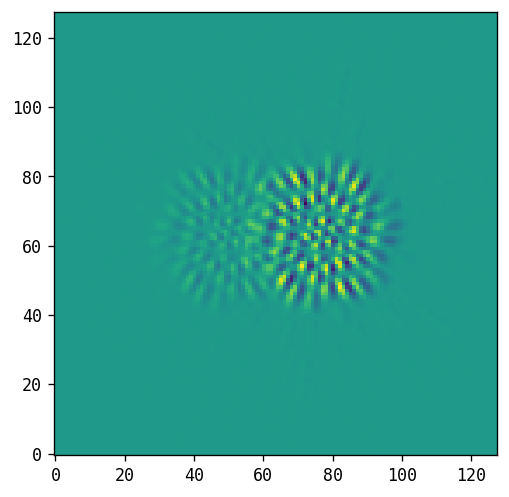

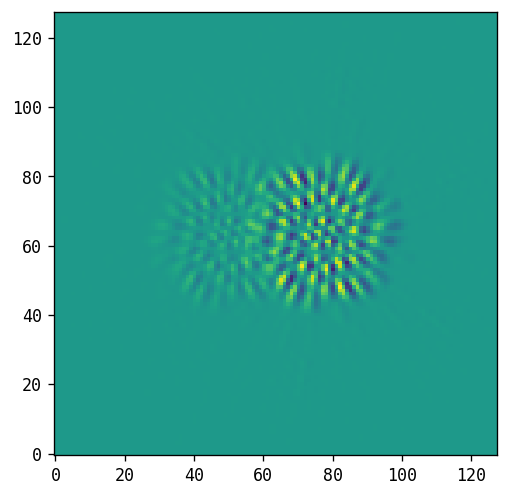

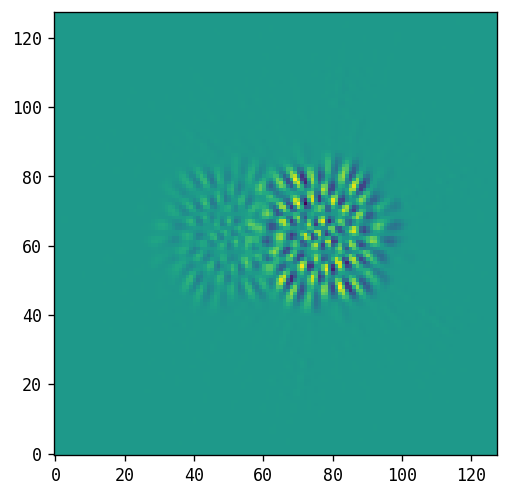

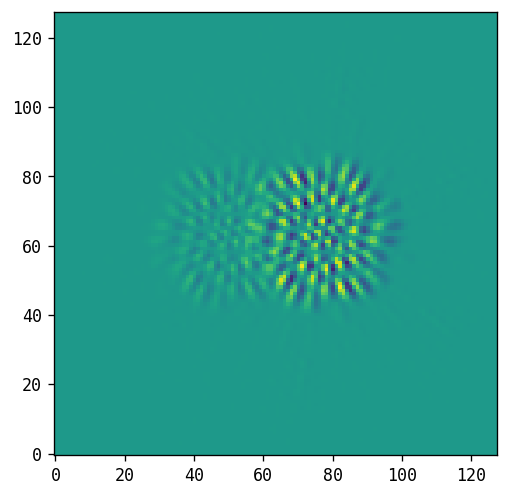

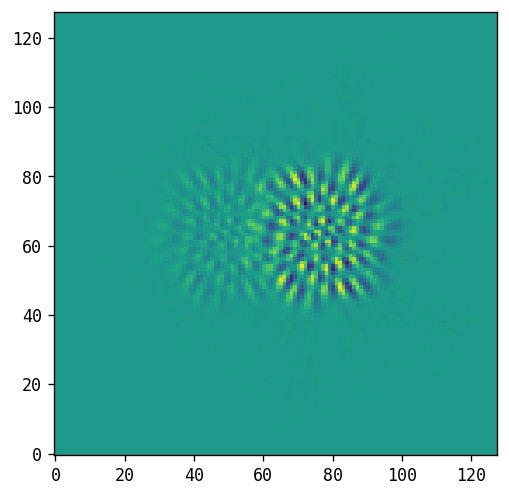

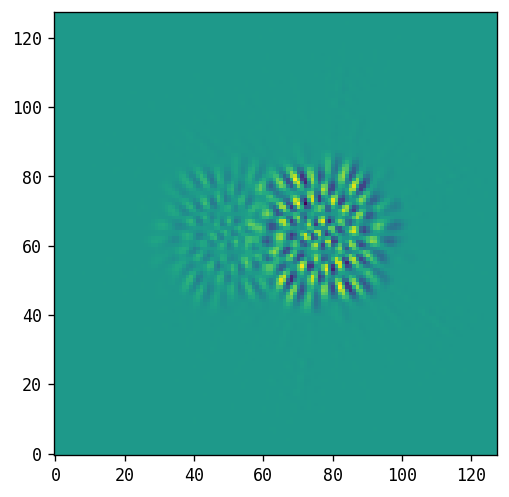

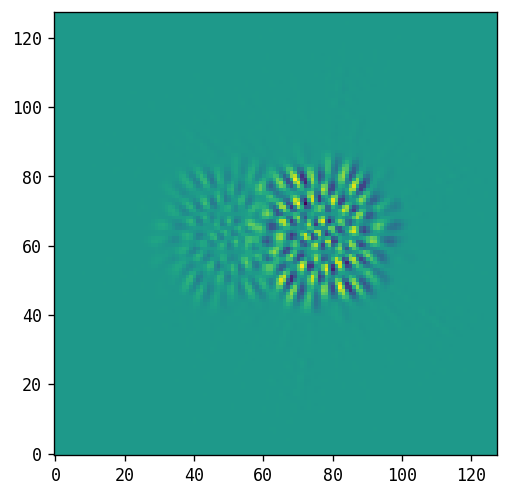

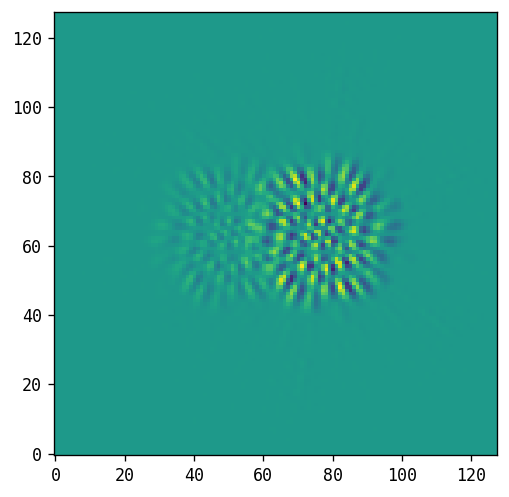

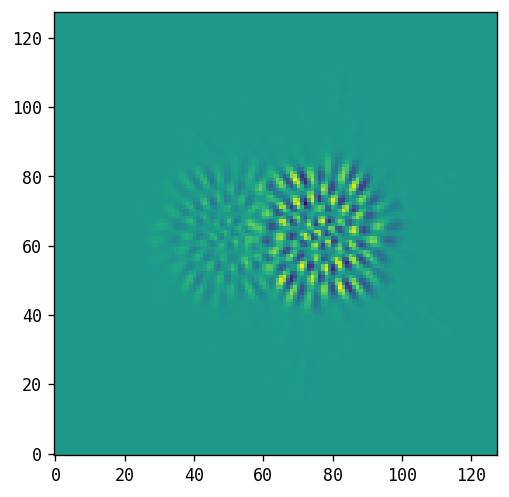

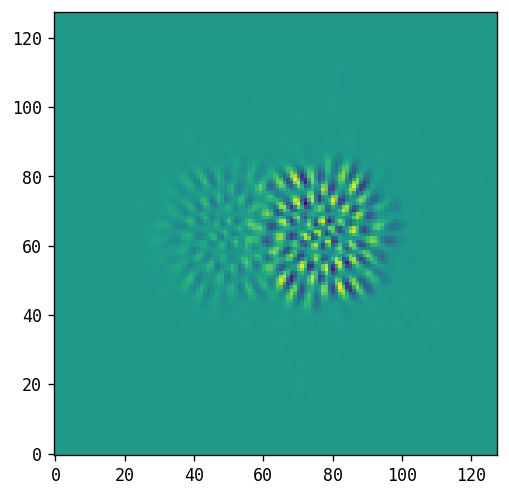

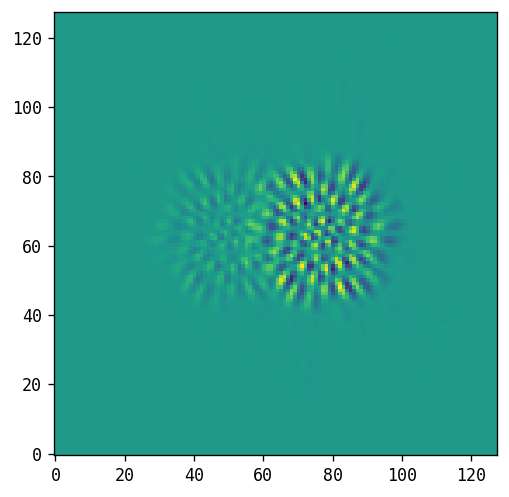

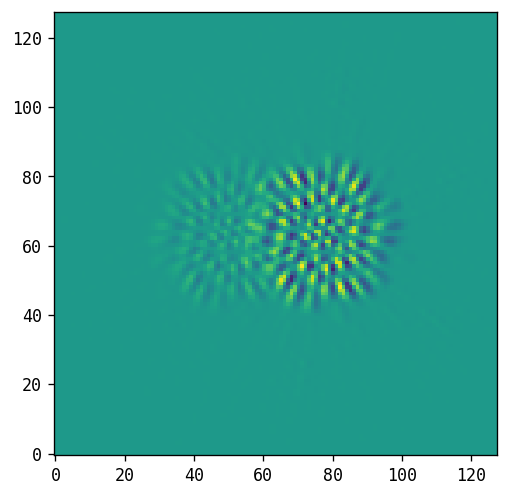

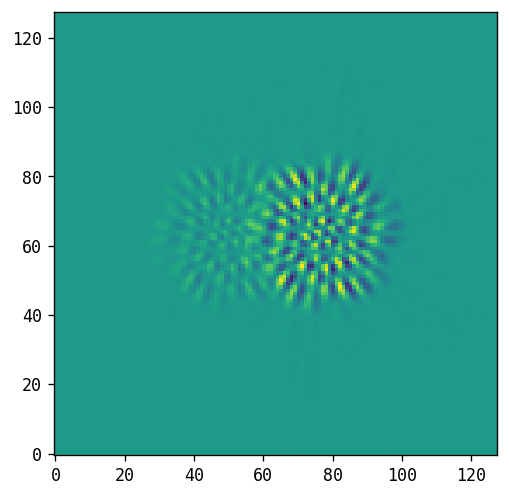

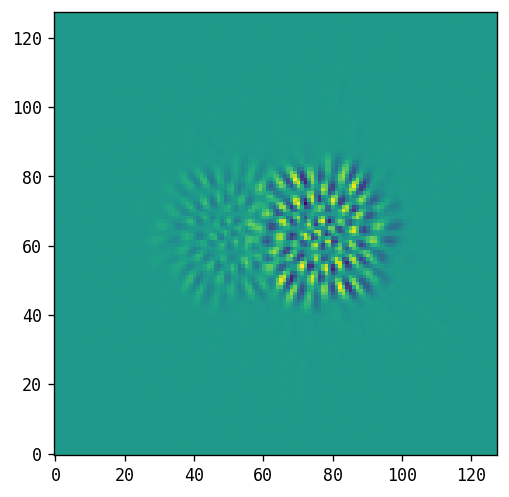

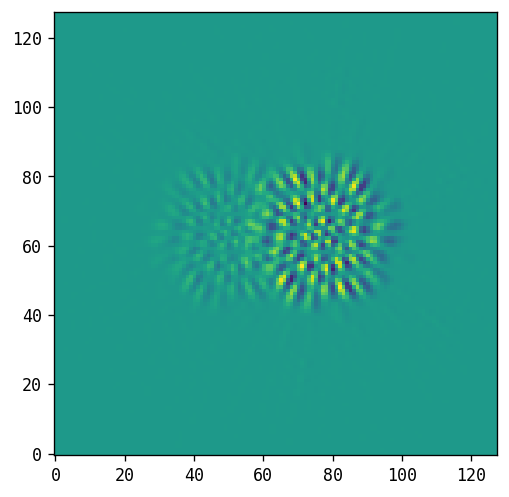

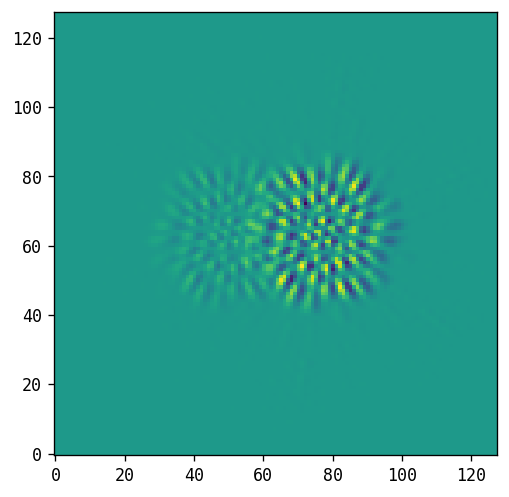

  0%|          | 0/40 [00:00<?, ?it/s]

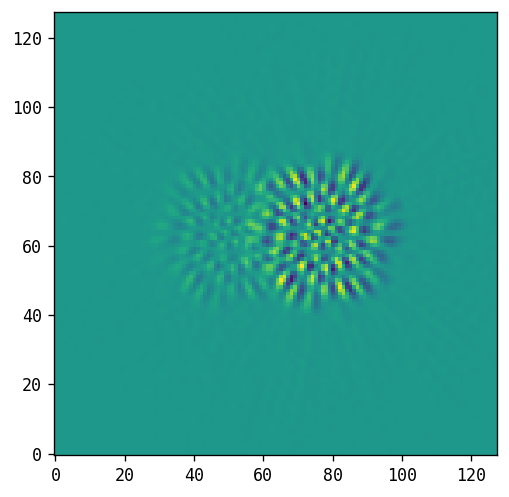

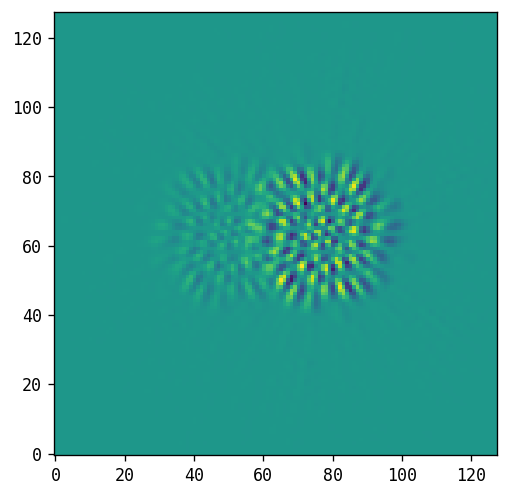

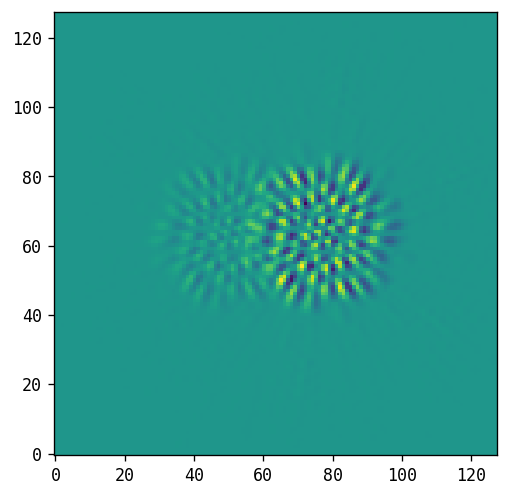

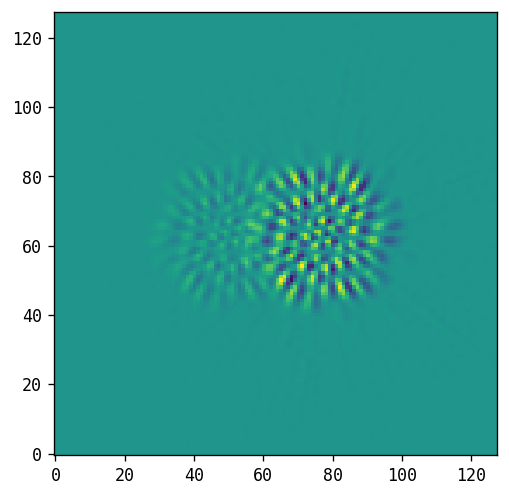

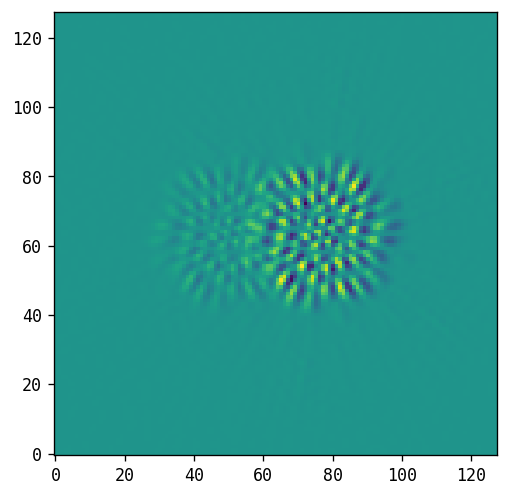

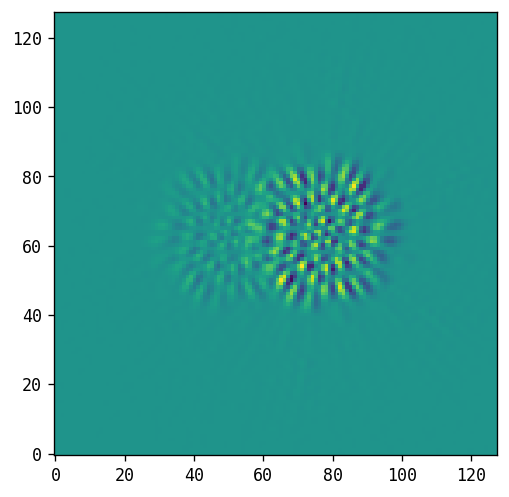

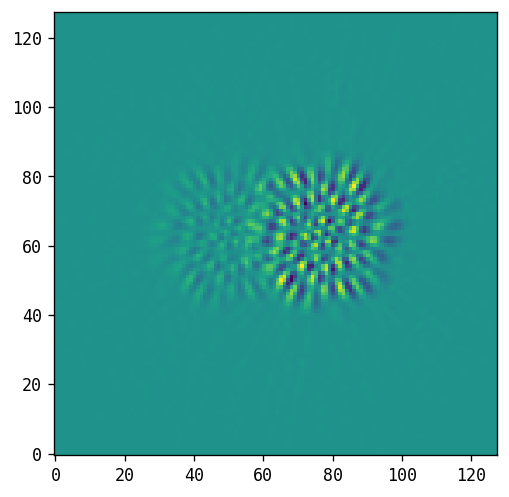

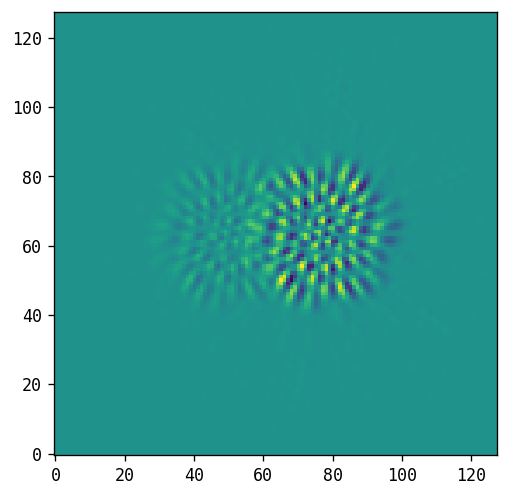

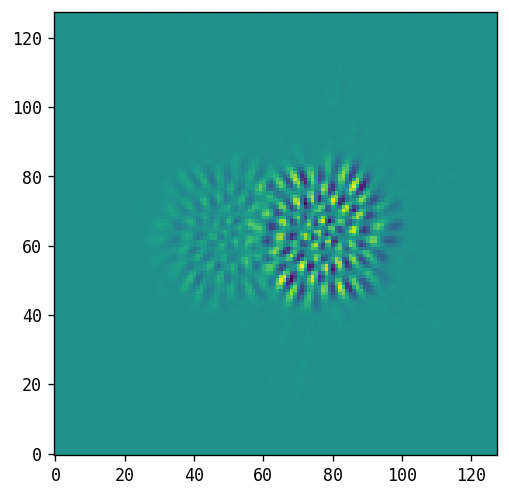

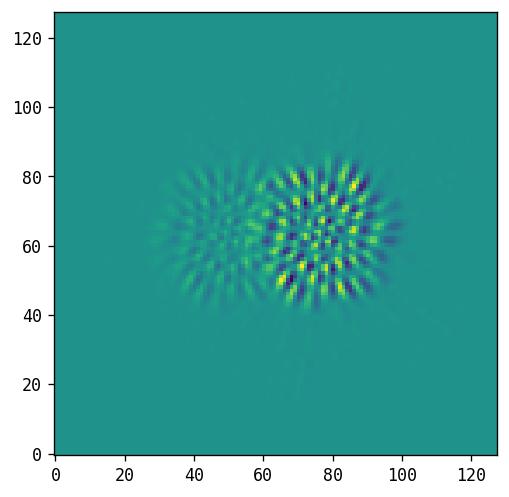

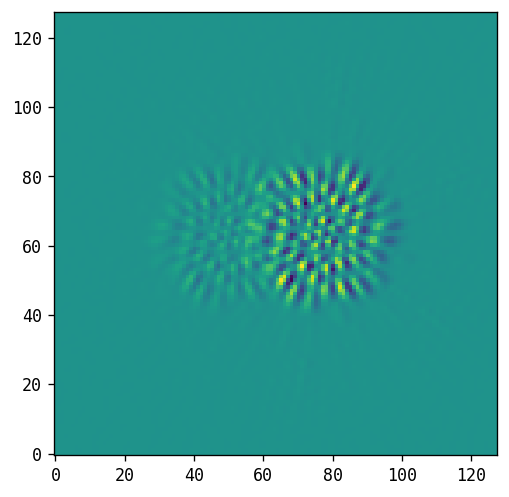

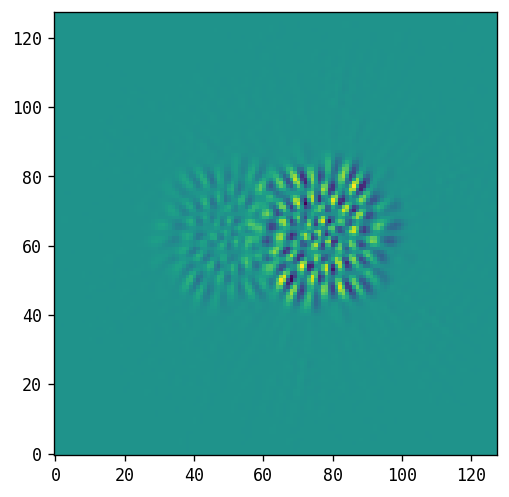

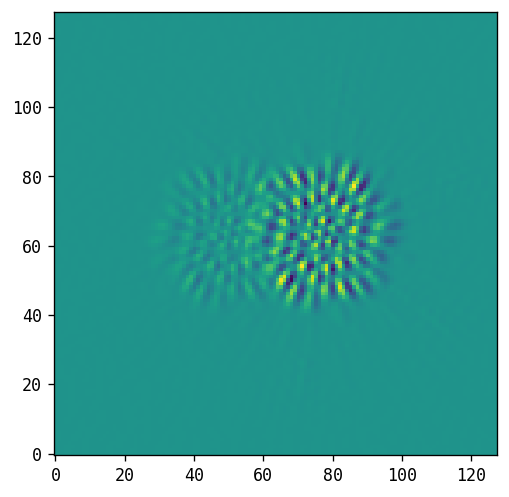

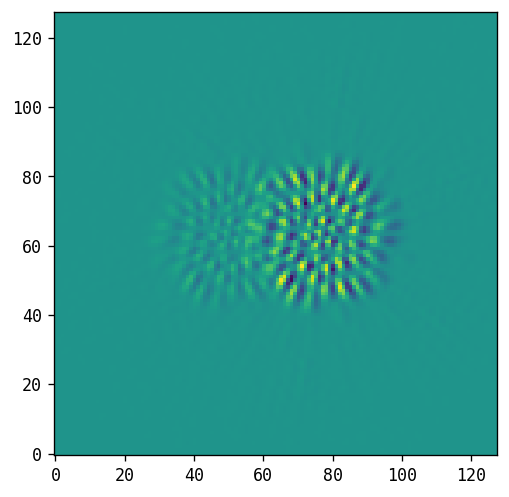

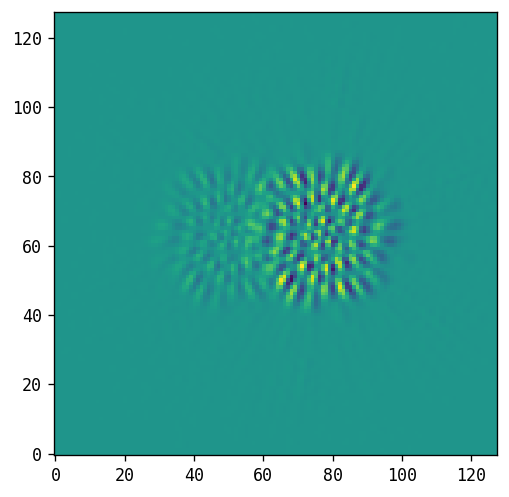

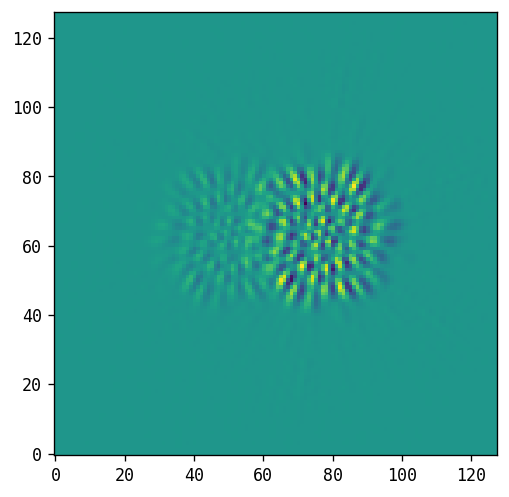

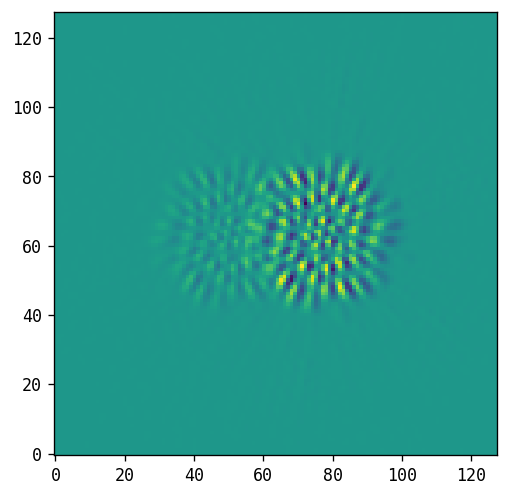

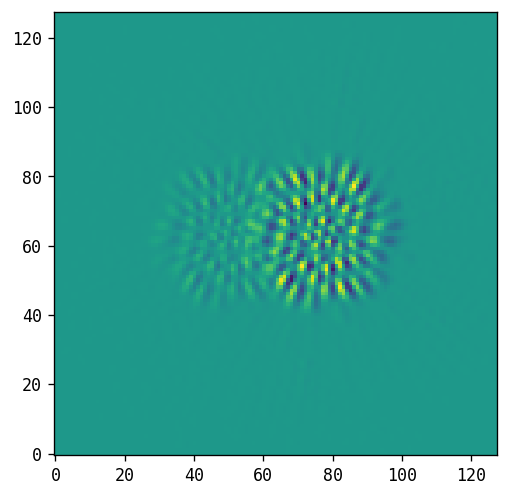

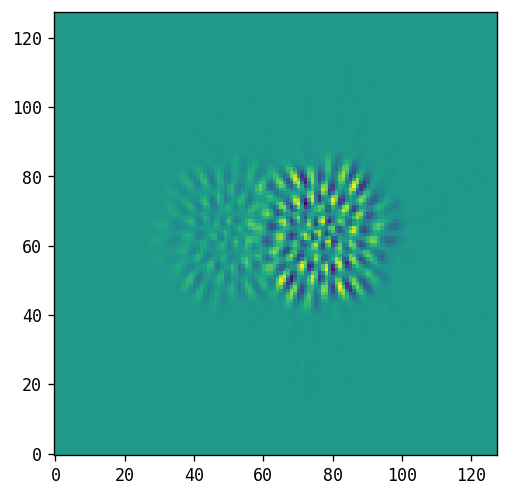

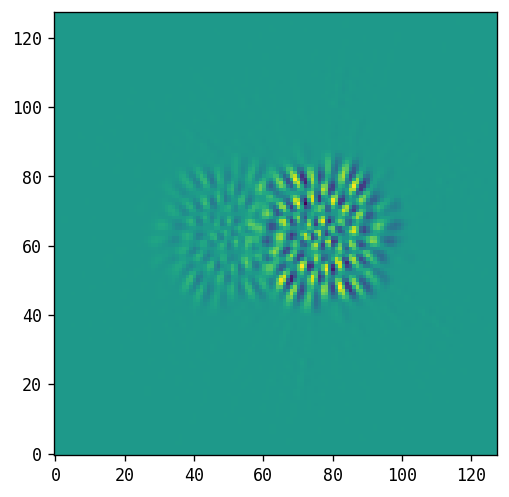

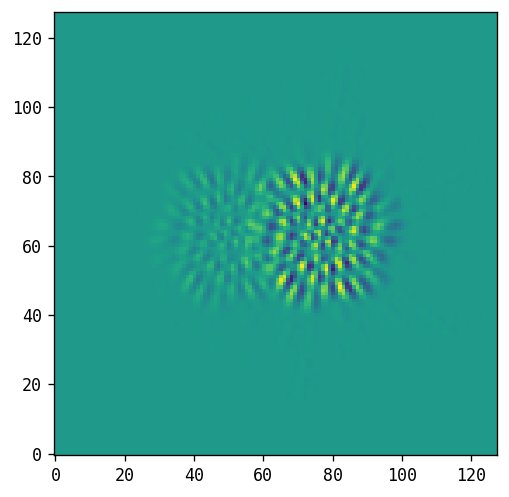

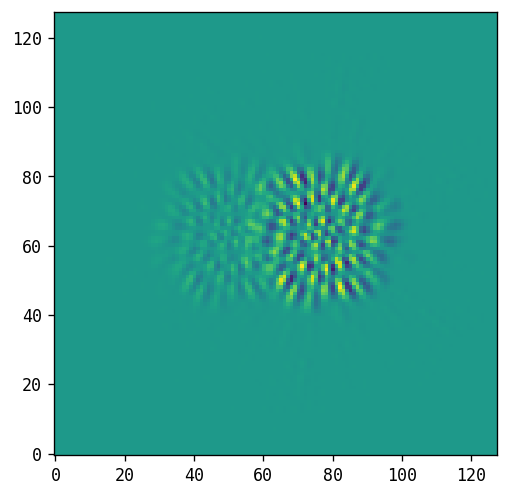

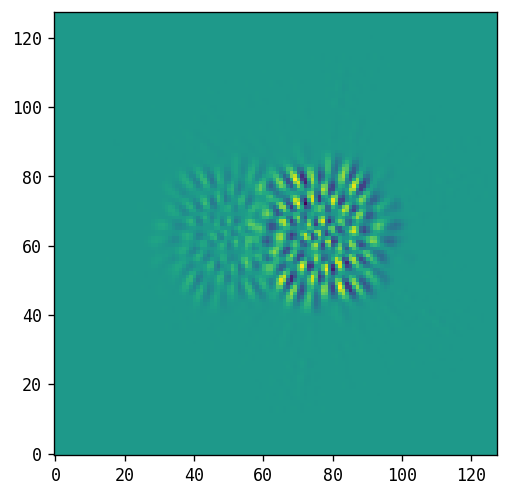

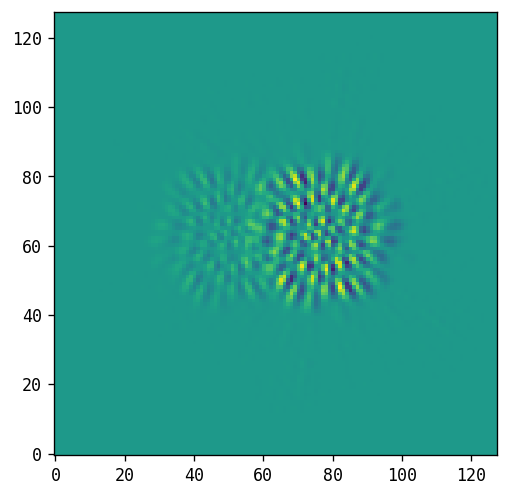

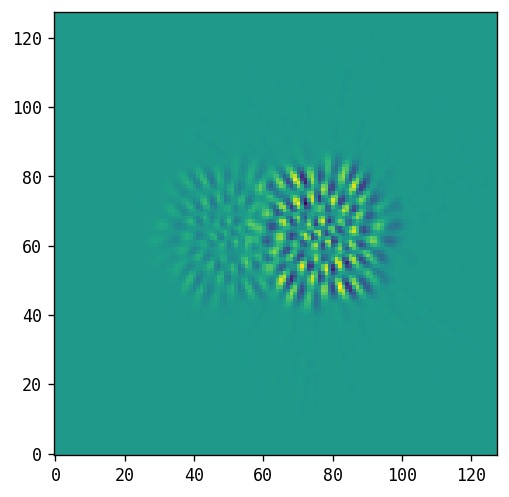

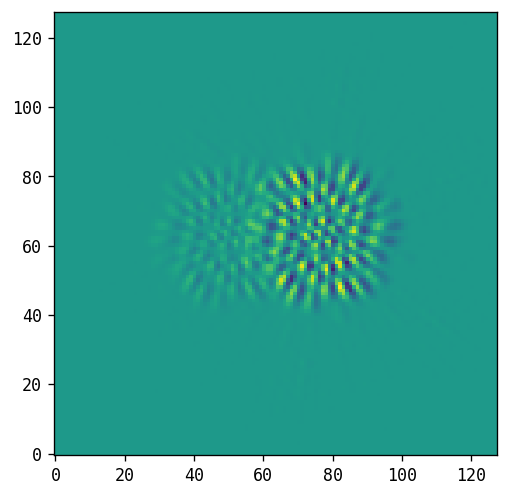

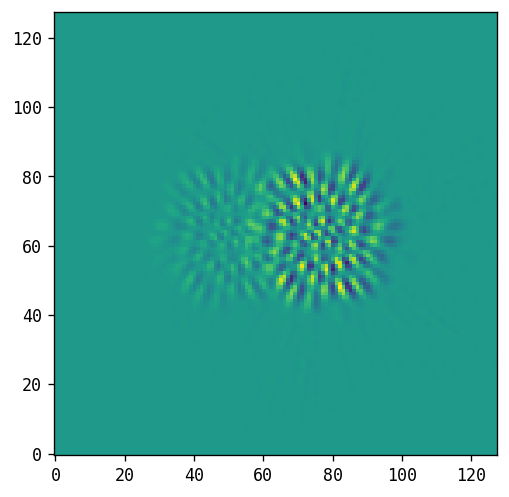

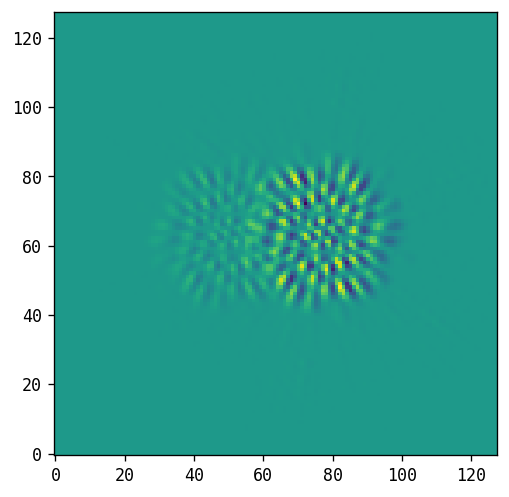

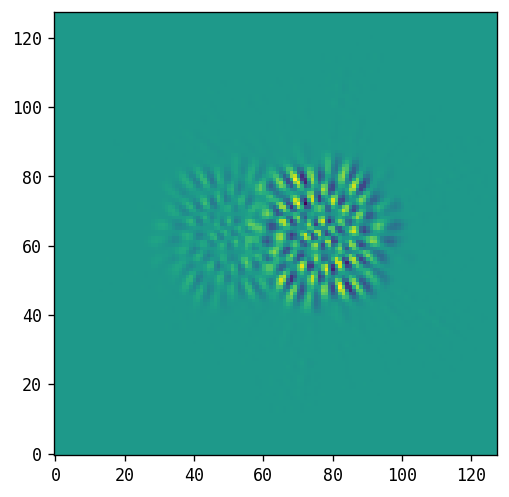

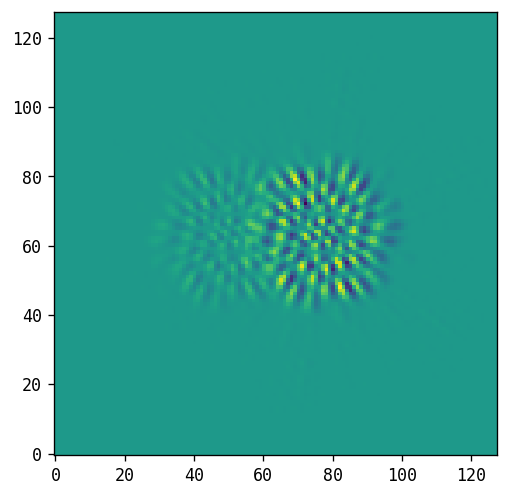

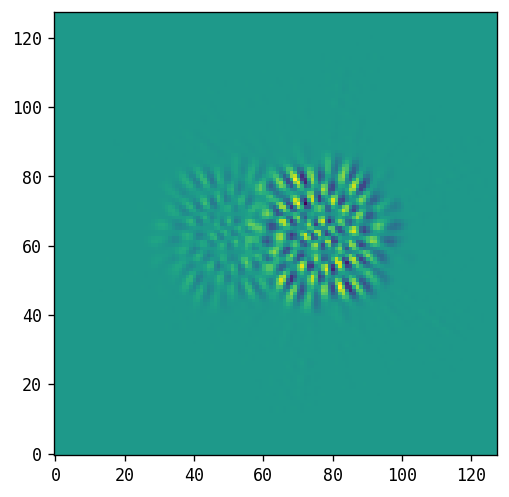

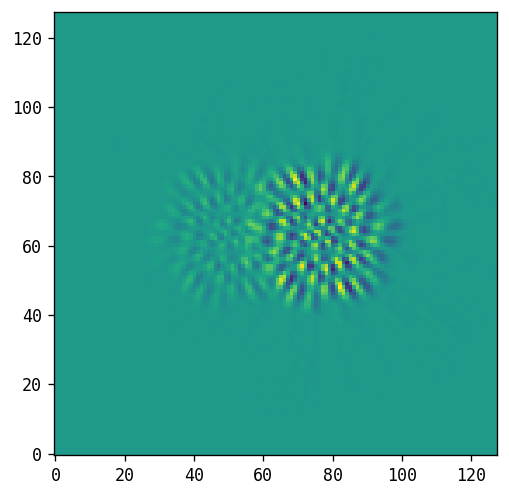

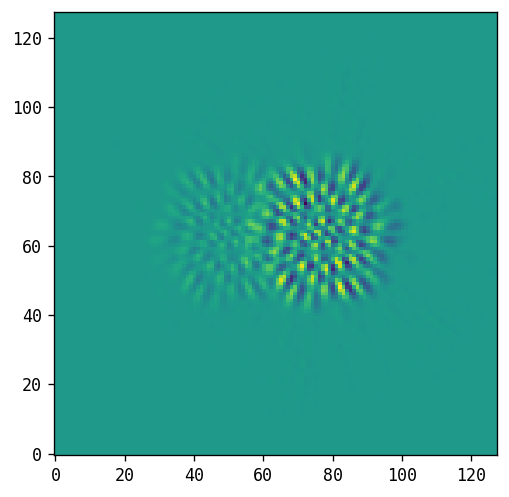

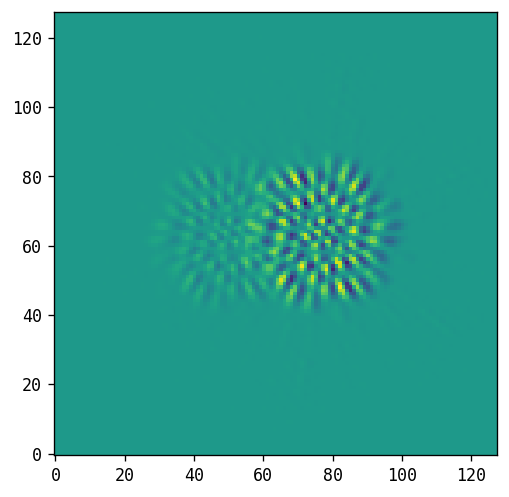

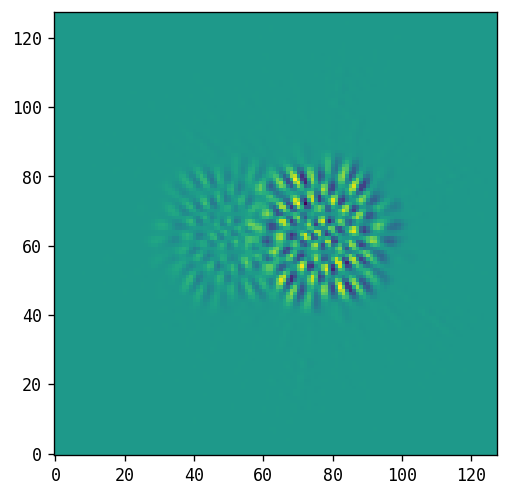

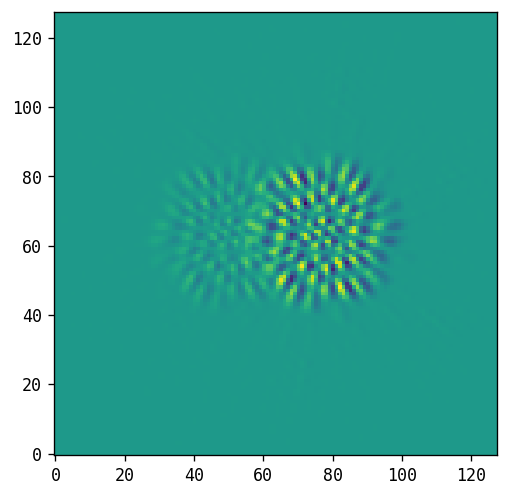

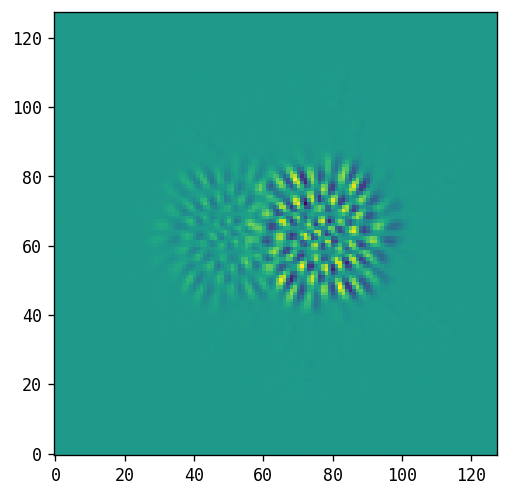

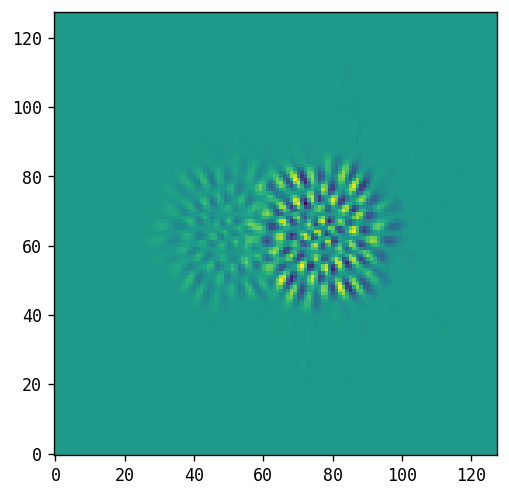

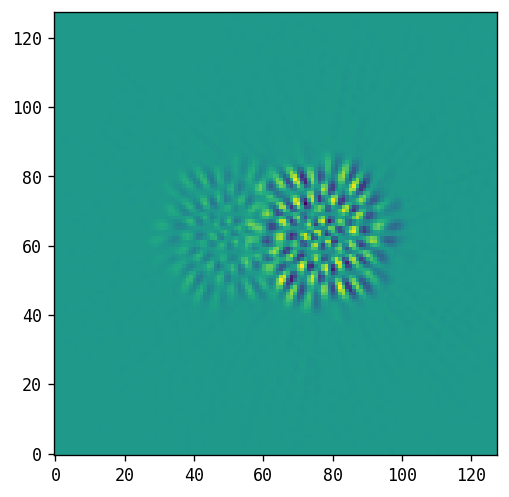

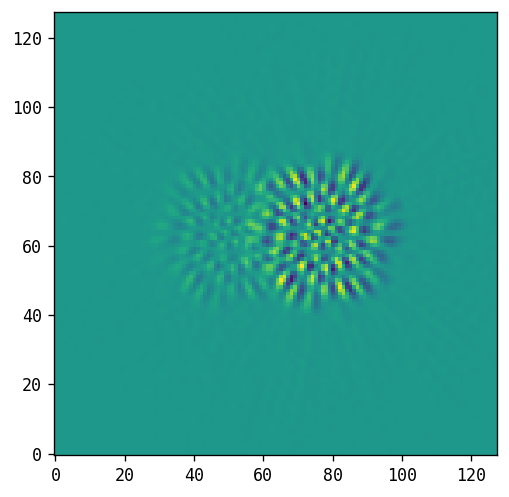

  0%|          | 0/40 [00:00<?, ?it/s]

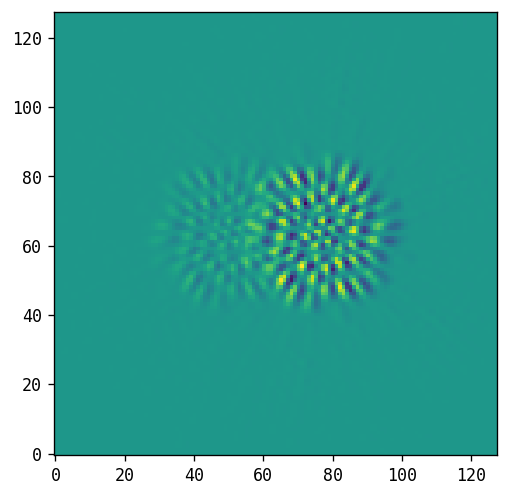

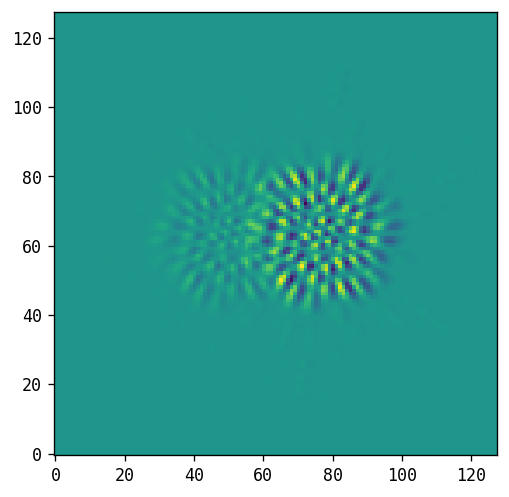

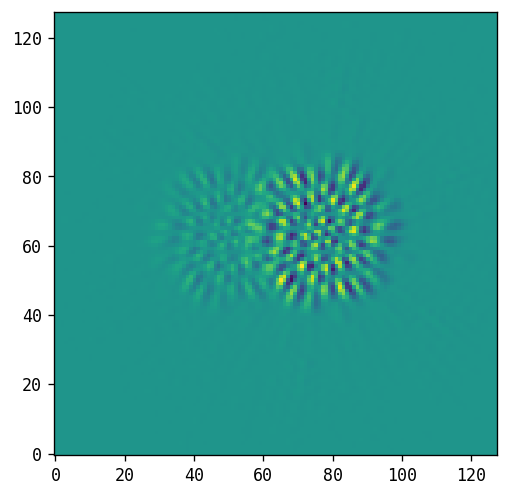

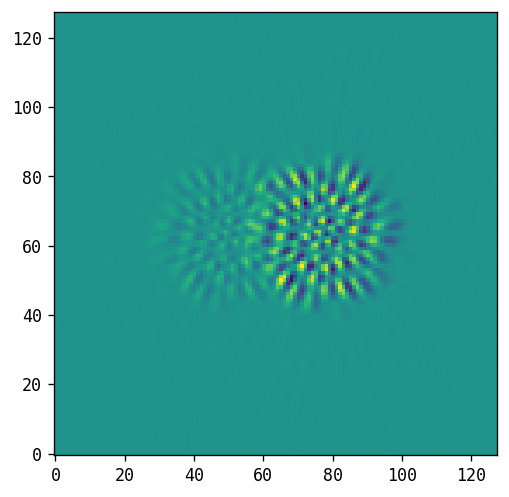

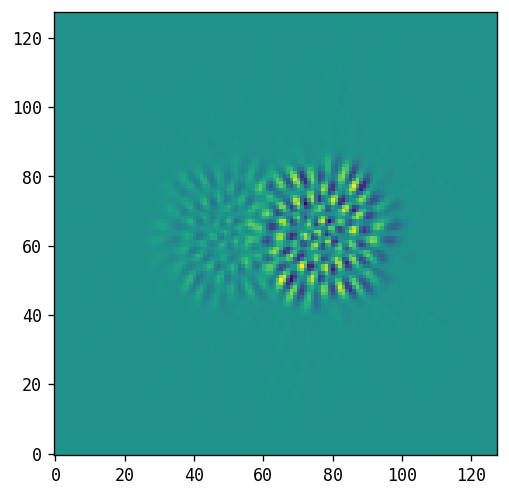

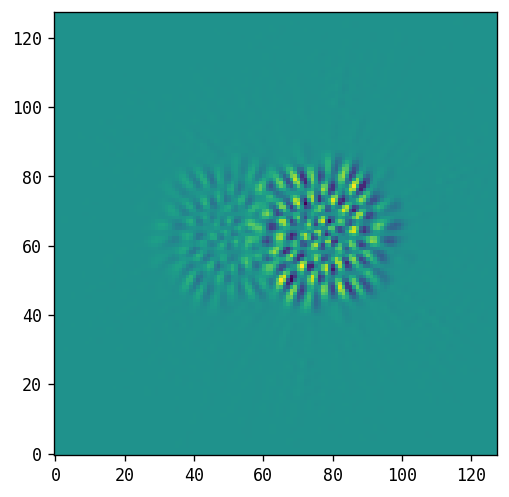

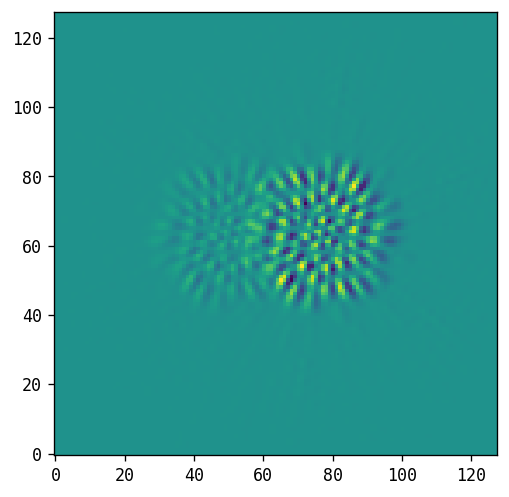

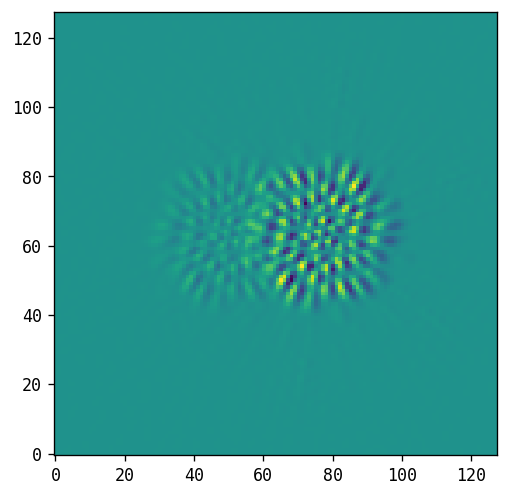

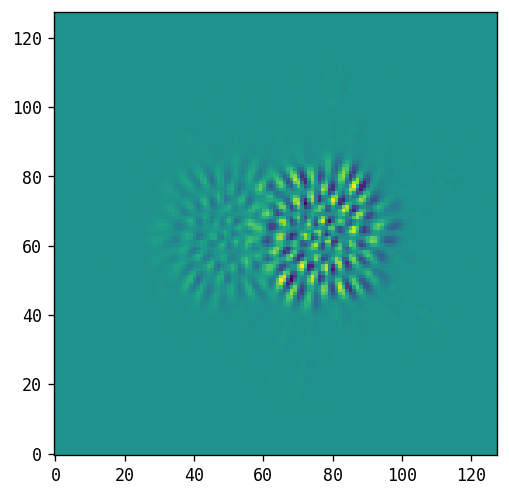

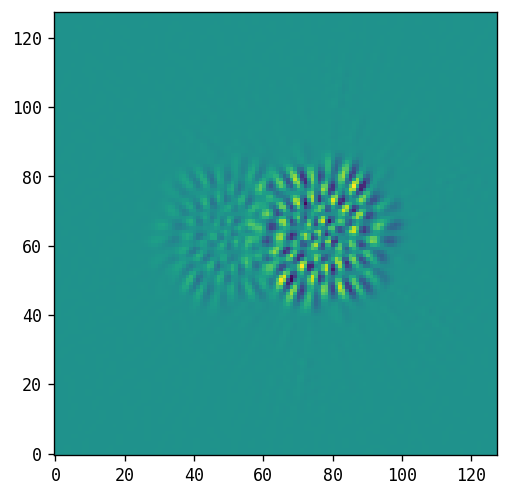

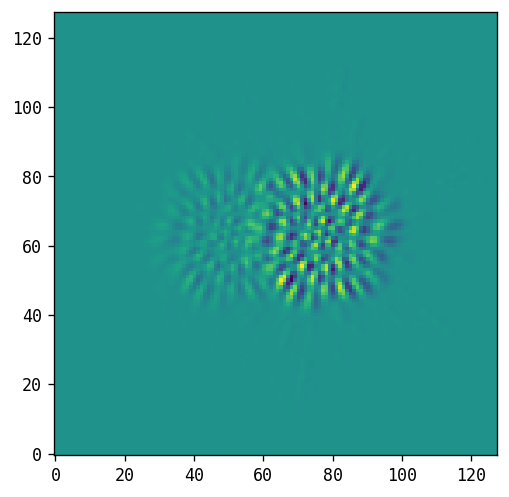

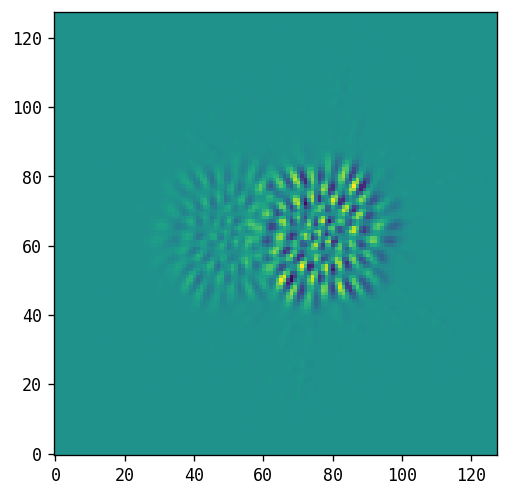

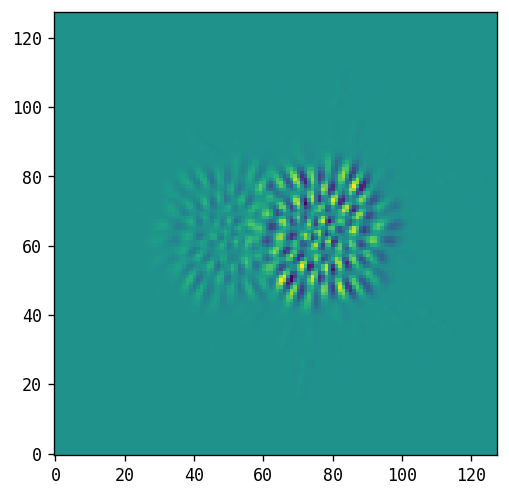

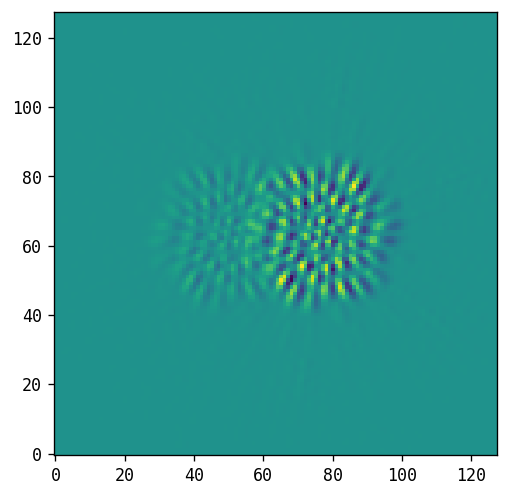

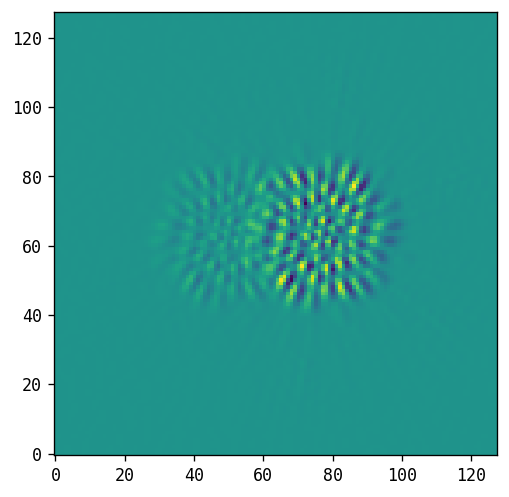

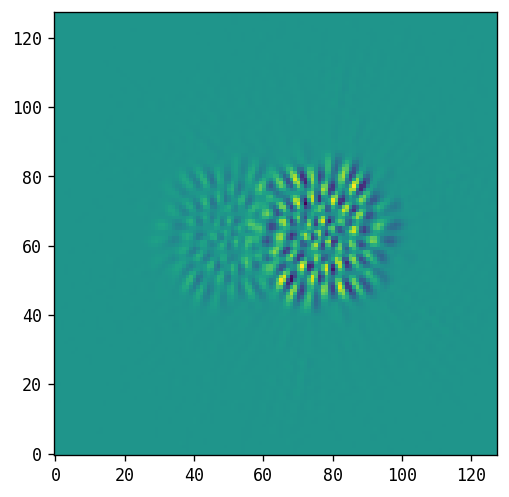

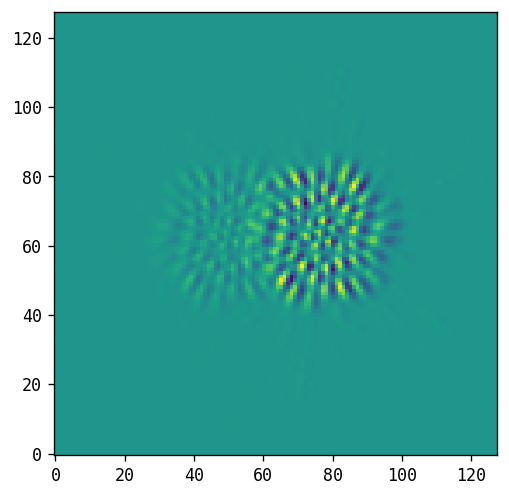

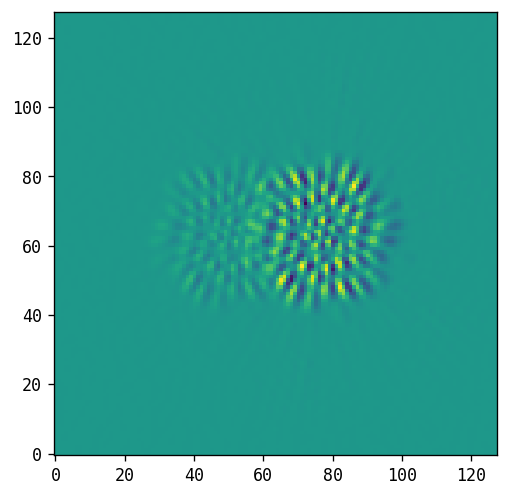

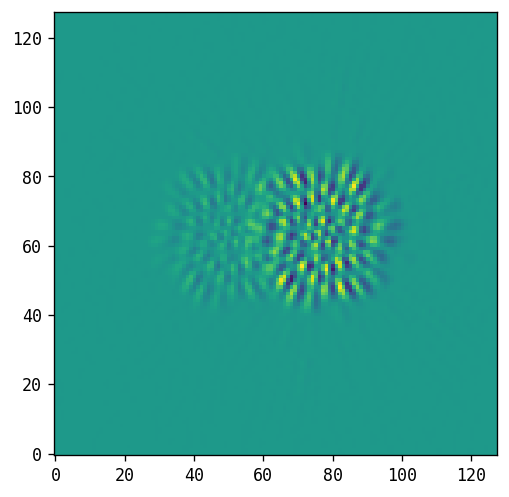

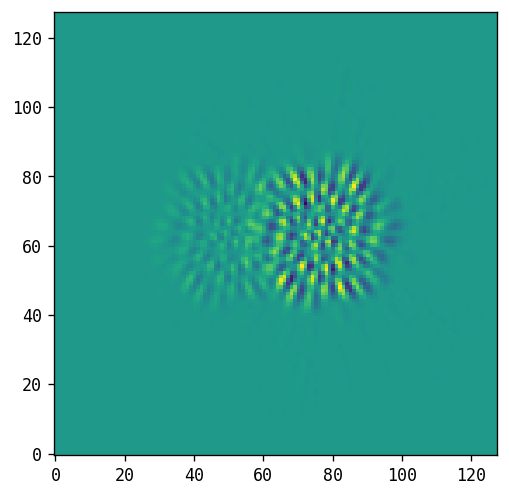

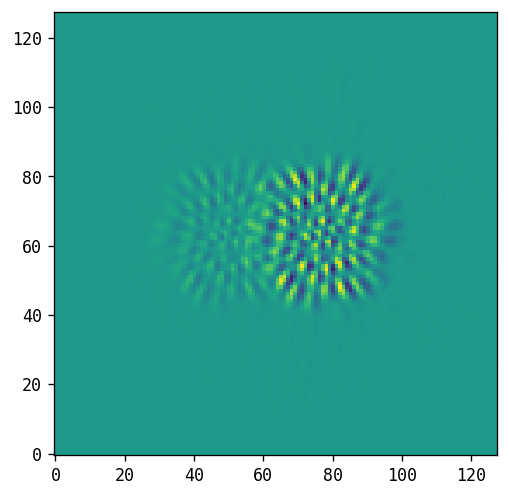

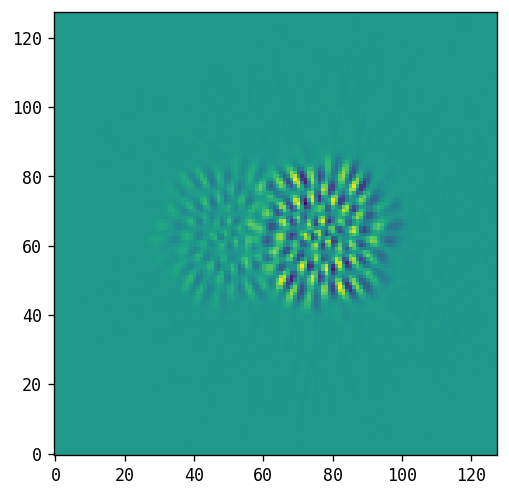

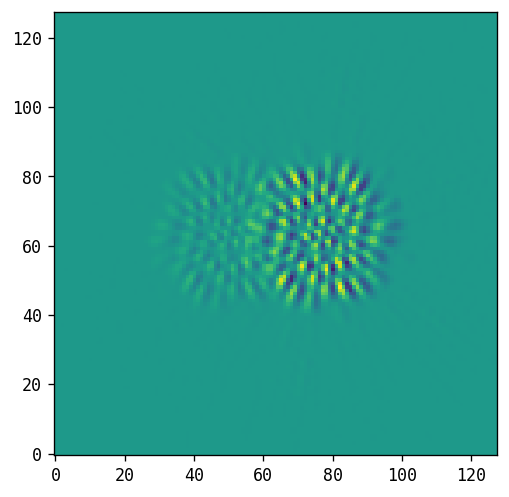

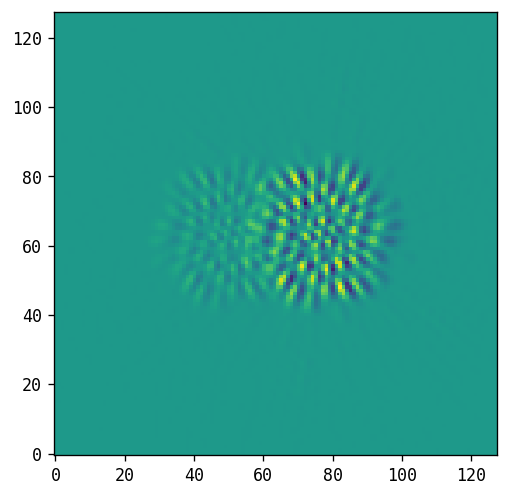

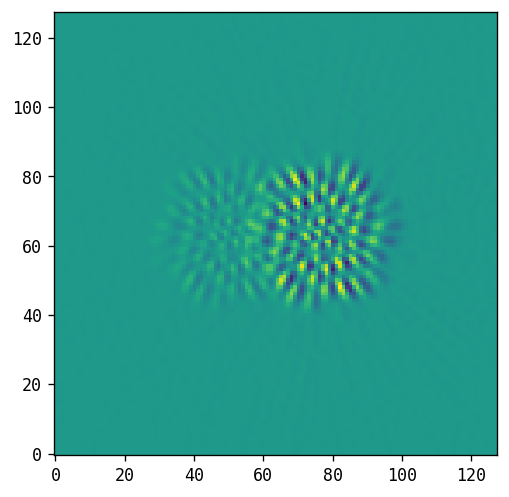

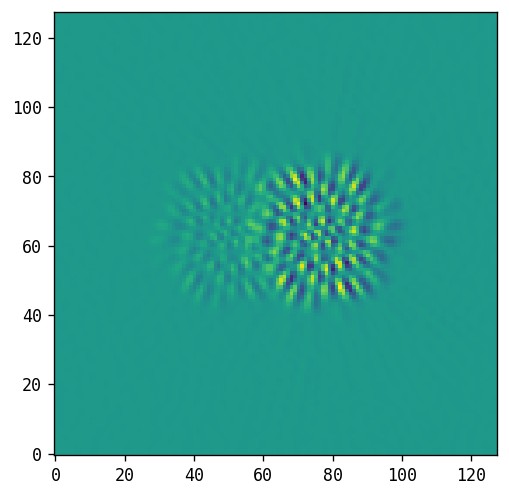

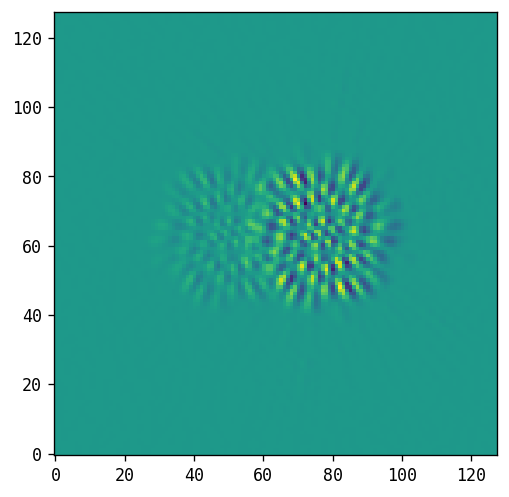

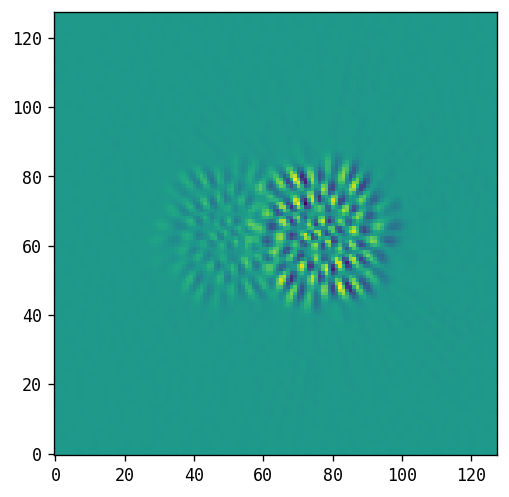

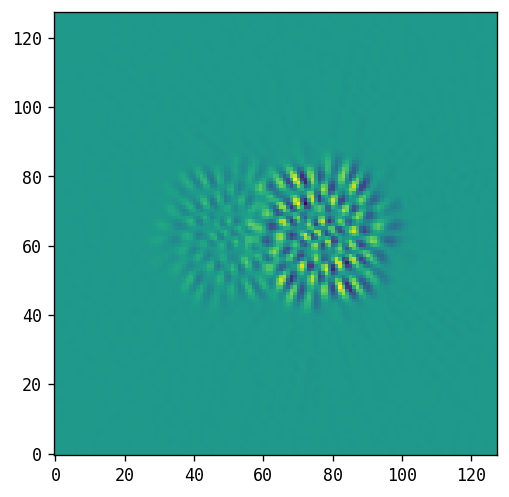

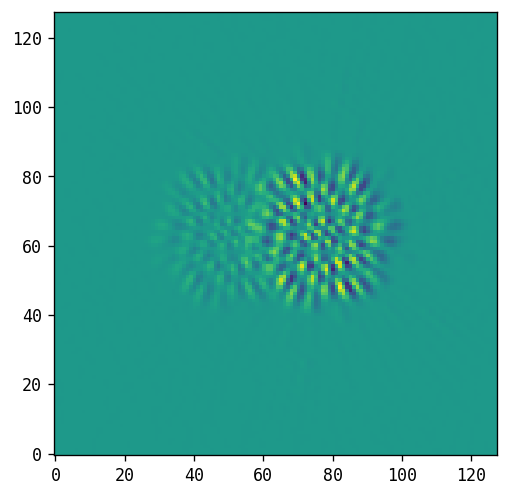

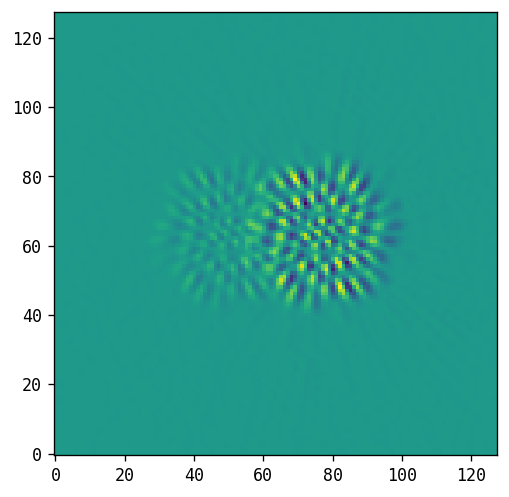

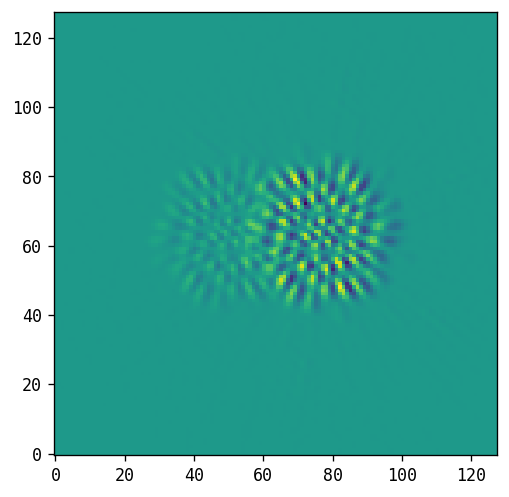

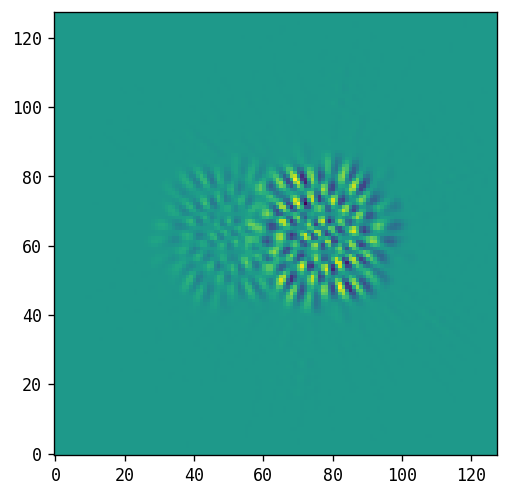

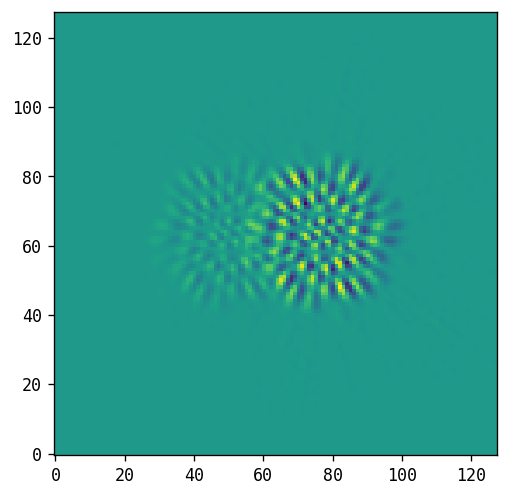

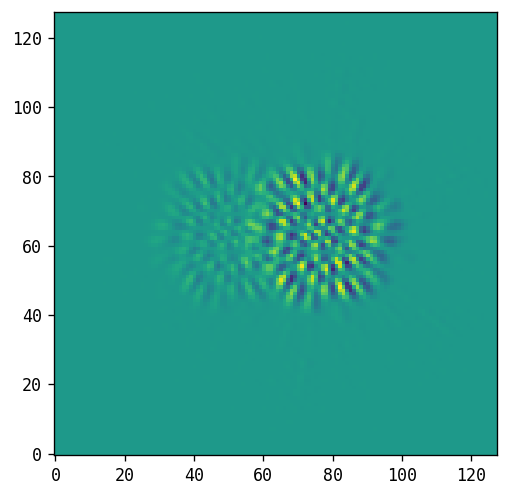

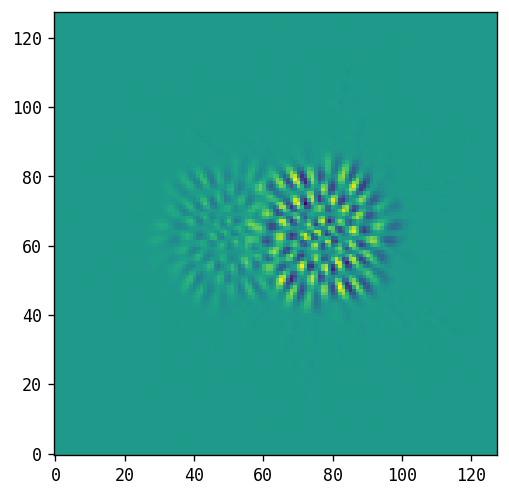

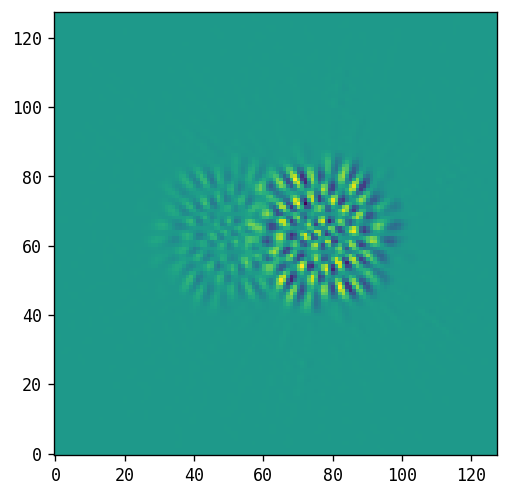

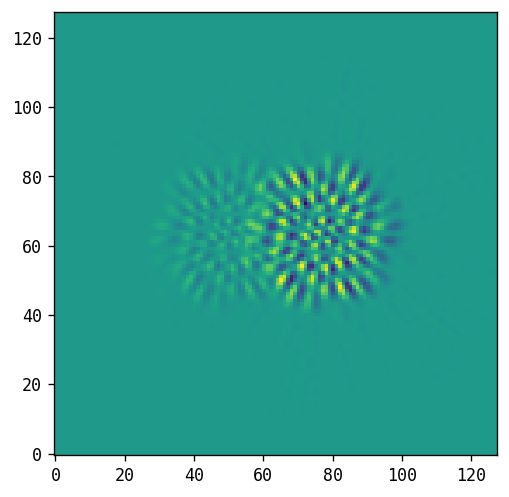

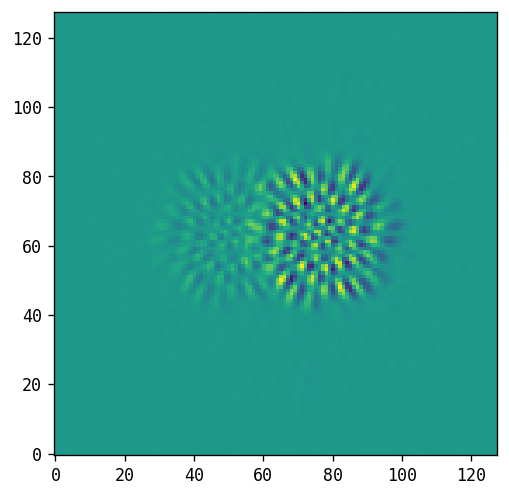

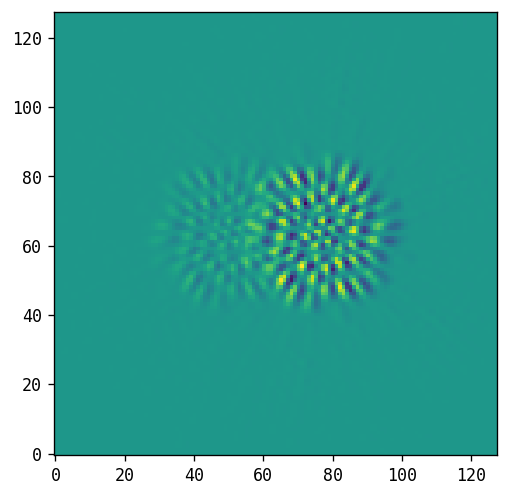

In [13]:
m = telescope
m = m.set('Jitter.shear', 0.7)
m = m.set('Jitter.kernel_size', 19)

ges = []
bonus_rs = np.linspace(1e-4, 1e-3, 3)
bonus_phis = np.linspace(0, 180, 40)
for r in tqdm(bonus_rs):
    for phi in tqdm(bonus_phis):
        m = m.set('Jitter.r', r)
        m = m.set('Jitter.phi', phi)
        psf = m.model()
        # plt.imshow(psf)
        # plt.show()

        # GE = dlT.gradient_energy.get_GE(psf)
        GE = np.gradient(psf)[1]
        plt.imshow(GE, cmap='viridis')
        plt.show()

        # plt.imshow(m.Jitter.generate_kernel(det_pscale/oversample), cmap='YlGnBu_r')
        # plt.show()

        ges.append(GE.sum())

ges = np.array(ges).reshape(len(bonus_rs), len(bonus_phis))


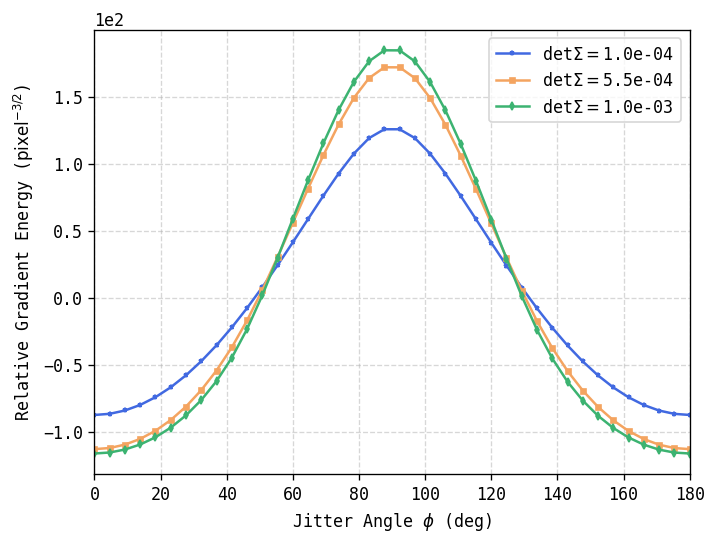

In [14]:
fig, ax = plt.subplots()
colors = ['royalblue', 'sandybrown', 'mediumseagreen']
markers = ['*', 's', 'd']
for i, r in enumerate(bonus_rs):
    ax.plot(bonus_phis, ((ges[i] - ges[i].mean())), label=r"det$\Sigma = $" + f"{r:.1e}", marker=markers[i], markersize=3, c=colors[i])
ax.set(
    xlabel=r'Jitter Angle $\phi$ (deg)',
    ylabel=r'Relative Gradient Energy ($\text{pixel}^{-3/2}$)',
    xlim=(0, 180),
)
ax.legend()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 2))
ax.grid(True, alpha=0.5, linestyle='--')
# plt.savefig('figs/gradient_energy.pdf', bbox_inches='tight')
plt.show()